This workbook is to accompany the towardsdatascience.com blog post **"Variational Bayesian inference with normalizing flows: a simple example"**

This workbook is for a **fixed effects model** fitted to the WinBUGS rat data using variational inference with various **surrogate posteriors**. The original rats examples uses random effects which is slightly more complex. The code below can be adapted to the random effects case with some small changes. 

# RATS MODEL in BUGS Language

In [ ]:
# original model
# model {
#    for (i in 1:N) {
#       for (j in 1:T) {
#          mu[i,j] <- alpha[i] + beta[i]*x[j];
#          Y[i,j]   ~ dnorm(mu[i,j],tau.c)
#       }
#       alpha[i] ~ dnorm(alpha.c,tau.alpha);
#       beta[i]  ~ dnorm(beta.c,tau.beta);
#    }
#    alpha.c   ~ dnorm(0,1.0E-4);
#    beta.c    ~ dnorm(0,1.0E-4);
#    tau.c     ~ dgamma(1.0E-3,1.0E-3);
#    tau.alpha ~ dgamma(1.0E-3,1.0E-3);
#    tau.beta  ~ dgamma(1.0E-3,1.0E-3);
#}


# simplified model using only fixed effects
# model {
#    for (i in 1:N) {
#   
#          mu[i] <- alpha + beta*x[i];
#          Y[i]   ~ dnorm(mu[i],tau.c)
#       }
#       alpha ~ dnorm(alpha.c,tau.alpha);
#       beta  ~ dnorm(beta.c,tau.beta);
#    
#    alpha.c   ~ dnorm(0,1.0E-4);
#    beta.c    ~ dnorm(0,1.0E-4);
#    tau.c     ~ dgamma(1.0E-3,1.0E-3);
#    tau.alpha ~ dgamma(1.0E-3,1.0E-3);
#    tau.beta  ~ dgamma(1.0E-3,1.0E-3);
#}


#Setup Packages
Need specific version to ensure access to *.experimental functions in API

In [ ]:
!pip3 install tensorflow==2.6.0rc0 tensorflow_probability==0.13.0


     |████████████████████████████████| 456.5 MB 21 kB/s 
     |████████████████████████████████| 463 kB 58.7 MB/s 
     |████████████████████████████████| 1.3 MB 57.0 MB/s 
     |████████████████████████████████| 4.3 MB 46.4 MB/s 
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30693 sha256=863d7b6d9780ba7e9cfa2e5f7550c6674041c2a4506be9d08cff14d08bec6295
  Stored in directory: /root/.cache/pip/wheels/98/91/04/971b4c587cf47ae952b108949b46926f426c02832d120a082a
Successfully built clang
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Attempting uninstall: keras
    Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
from six.moves import urllib

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import numpy as np
import pandas as pd
import seaborn as sns; sns.set_context('notebook')
import tensorflow_datasets as tfds

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
print(tfp.__version__)
print(tf.__version__)

0.13.0
2.6.0-rc0


#Data setup + engineering
Hard code the raw data so notebook is self-contained
<br><br>Notes: 
manipulate the data into vectors then tensors, other options are possible, this is a simple approach

In [ ]:
# some useful globals
g_showData=True # print data after manipulation
g_showProb=True # print output of prob density as a check


In [ ]:
### data from R, rats raw
N=30 # number of rats
T=5  # number of time points 
## REPONSE Y
Y=np.array( # note this is one long vector - filled by COLUMNS 
    [151, 145, 147, 155, 135, 159, 141, 159, 177, 134, 
160, 143, 154, 171, 163, 160, 142, 156, 157, 152, 154, 139, 146, 
157, 132, 160, 169, 157, 137, 153, 199, 199, 214, 200, 188, 210, 
189, 201, 236, 182, 208, 188, 200, 221, 216, 207, 187, 203, 212, 
203, 205, 190, 191, 211, 185, 207, 216, 205, 180, 200, 246, 249, 
263, 237, 230, 252, 231, 248, 285, 220, 261, 220, 244, 270, 242, 
248, 234, 243, 259, 246, 253, 225, 229, 250, 237, 257, 261, 248, 
219, 244, 283, 293, 312, 272, 280, 298, 275, 297, 350, 260, 313, 
273, 289, 326, 281, 288, 280, 283, 307, 286, 298, 267, 272, 285, 
286, 303, 295, 289, 258, 286, 320, 354, 328, 297, 323, 331, 305, 
338, 376, 296, 352, 314, 325, 358, 312, 324, 316, 317, 336, 321, 
334, 302, 302, 323, 331, 345, 333, 316, 291, 324],dtype=float)

# now reshape, first into the original format in WinBUGS, each row with 5 obs
Y=np.reshape(Y,(30,-1),'F') # N rows by T cols, fill by cols = Fortan like

# now reshape into one long single col filled by row. going for long format
Y=np.reshape(Y,(150,),'C') # numpy VECTOR

# COVARIATE X=age
# age of rats in days
X = np.array([8.0, 15.0, 22.0, 29.0, 36.0],dtype=float)
# replicate to give 8,15,22,29,36, 8,15,22,29,36,....
X=np.reshape([X for i in range(N)],(-1,),'C') # numpy VECTOR

# rat ID - not current used
# 0 0 0 0 0 1 1 1 1....
id=np.reshape(np.repeat(list(range(0,30,1)),5),(-1,),'C')

[Text(0.5, 0, 'Age (days)')]

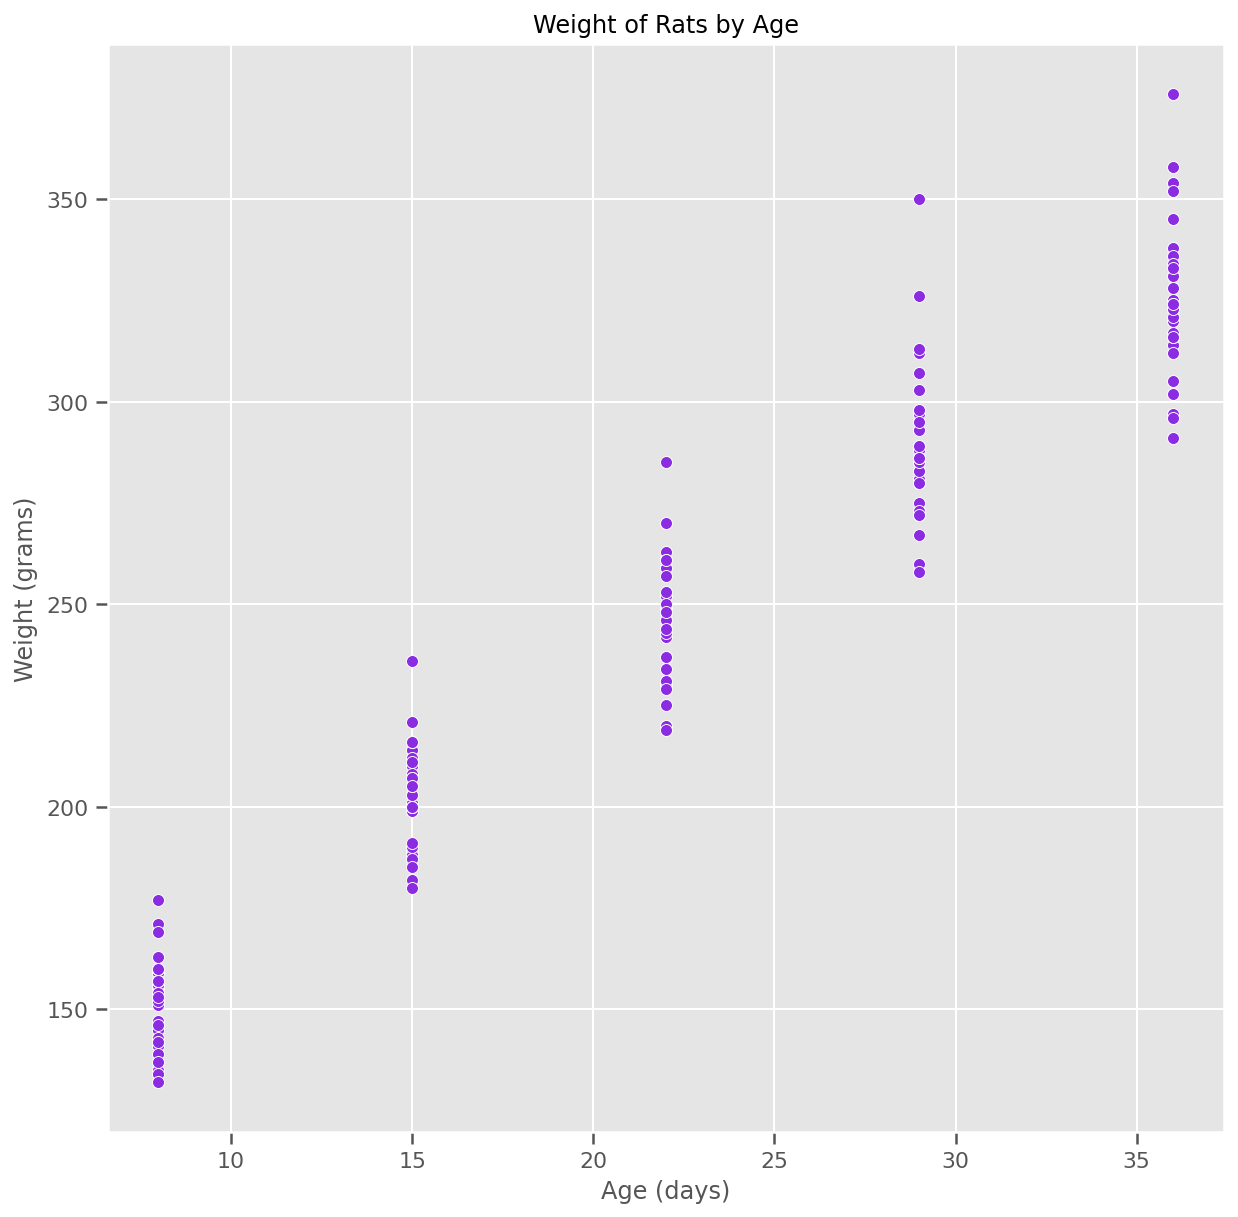

In [ ]:
from google.colab import files
#from google.colab import drive # only need to save files to local google drive
#drive.mount('/content/drive')
#fig, axes = plt.subplots(2, 2, figsize=(10, 10))
plt.figure(figsize=(10,10))
sns.set_color_codes("bright") # deep, muted, pastel, dark, bright, colorblind
myplot=sns.scatterplot(x=X,y=Y,color='m')
#myplot.set(ylim=(600, 2000))
myplot.set(title="Weight of Rats by Age")
myplot.set(ylabel="Weight (grams)")
myplot.set(xlabel="Age (days)")
#plt.savefig('/content/drive/My Drive/my.png')
#plt.savefig('my.png') # uncomment to get downloaded plot
#files.download("my.png") # uncomment to get downloaded plot

In [ ]:
if g_showData:
  print(Y)
  print(X)
  print(id)
  print(Y.shape)  

[151. 199. 246. 283. 320. 145. 199. 249. 293. 354. 147. 214. 263. 312.
 328. 155. 200. 237. 272. 297. 135. 188. 230. 280. 323. 159. 210. 252.
 298. 331. 141. 189. 231. 275. 305. 159. 201. 248. 297. 338. 177. 236.
 285. 350. 376. 134. 182. 220. 260. 296. 160. 208. 261. 313. 352. 143.
 188. 220. 273. 314. 154. 200. 244. 289. 325. 171. 221. 270. 326. 358.
 163. 216. 242. 281. 312. 160. 207. 248. 288. 324. 142. 187. 234. 280.
 316. 156. 203. 243. 283. 317. 157. 212. 259. 307. 336. 152. 203. 246.
 286. 321. 154. 205. 253. 298. 334. 139. 190. 225. 267. 302. 146. 191.
 229. 272. 302. 157. 211. 250. 285. 323. 132. 185. 237. 286. 331. 160.
 207. 257. 303. 345. 169. 216. 261. 295. 333. 157. 205. 248. 289. 316.
 137. 180. 219. 258. 291. 153. 200. 244. 286. 324.]
[ 8. 15. 22. 29. 36.  8. 15. 22. 29. 36.  8. 15. 22. 29. 36.  8. 15. 22.
 29. 36.  8. 15. 22. 29. 36.  8. 15. 22. 29. 36.  8. 15. 22. 29. 36.  8.
 15. 22. 29. 36.  8. 15. 22. 29. 36.  8. 15. 22. 29. 36.  8. 15. 22. 29.
 36.  8. 15. 22. 29

In [ ]:
# convert data to TF tensors - not strictly needed, but conversion to float32 *is* needed (TF error later without this)
Y=tf.convert_to_tensor(Y.astype('float32'))
X=tf.convert_to_tensor(X.astype('float32'))


# Define the probability model - likelihood and all priors

Notes:<br>
The joint distributions are built as **JointDistributionNamedAutoBatched** objects which means they are dictionaries. 
<br>Other options are to use arrays. As we are using **JointDistributionNamedAutoBatched** for the model it makes sense to also use it for the surrogate posterior. 

In [ ]:

model1=tfd.JointDistributionNamedAutoBatched({
  'alpha_c': tfd.Normal(loc=0.,scale=np.sqrt(1/1E-04).astype('float32')),
  'beta_c': tfd.Normal(loc=0.,scale=np.sqrt(1/1E-04).astype('float32')),
  'tau_alpha': tfd.Gamma(1.0E-3,1.0E-3),
  'tau_beta': tfd.Gamma(1.0E-3,1.0E-3),
  'tau_c': tfd.Gamma(1.0E-3,1.0E-3),
  #'tau_alpha': tfd.HalfNormal(scale=10), # alternatives not available in JAGS but probably a better choice now
  #'tau_beta': tfd.HalfNormal(scale=10),
  #'tau_c': tfd.HalfNormal(scale=10),

  'alpha_i' : lambda alpha_c, tau_alpha: tfd.Normal(loc=alpha_c,scale=tau_alpha),
  'beta_i':  lambda beta_c, tau_beta: tfd.Normal(loc=beta_c,scale=tau_beta),
  'likelihood' : lambda alpha_i, beta_i, tau_c: tfd.Normal(
      loc=alpha_i + beta_i*X, scale=tau_c)                                                            

})

In [ ]:
if g_showProb: # note if use half normal for scale in model1 then .log_prob is fine, using gamma with 1E-3 can give nan due to tiny numbers
  tf.random.set_seed(990)
  a=model1.sample()
  print(a)
  print(model1.log_prob(a))
  print(f'log_like={model1.log_prob(a)}')

{'tau_beta': <tf.Tensor: shape=(), dtype=float32, numpy=1.1754944e-38>, 'beta_c': <tf.Tensor: shape=(), dtype=float32, numpy=-79.42197>, 'beta_i': <tf.Tensor: shape=(), dtype=float32, numpy=-79.42197>, 'tau_alpha': <tf.Tensor: shape=(), dtype=float32, numpy=1.1754944e-38>, 'alpha_c': <tf.Tensor: shape=(), dtype=float32, numpy=-191.05162>, 'alpha_i': <tf.Tensor: shape=(), dtype=float32, numpy=-191.05162>, 'tau_c': <tf.Tensor: shape=(), dtype=float32, numpy=1.1754944e-38>, 'likelihood': <tf.Tensor: shape=(150,), dtype=float32, numpy=
array([ -826.42737, -1382.3811 , -1938.3348 , -2494.2886 , -3050.2424 ,
        -826.42737, -1382.3811 , -1938.3348 , -2494.2886 , -3050.2424 ,
        -826.42737, -1382.3811 , -1938.3348 , -2494.2886 , -3050.2424 ,
        -826.42737, -1382.3811 , -1938.3348 , -2494.2886 , -3050.2424 ,
        -826.42737, -1382.3811 , -1938.3348 , -2494.2886 , -3050.2424 ,
        -826.42737, -1382.3811 , -1938.3348 , -2494.2886 , -3050.2424 ,
        -826.42737, -1382.3811

In [ ]:
# Pin the observed response variable `weight` to model to give the un-normalized posterior.
# this is essential for the below calls to work
target_model1 = model1.experimental_pin(likelihood=Y)

In [ ]:
# this is not essential, just some info and debugging to make sure the prob dists are setup correctly
if g_showProb:
  tf.random.set_seed(9999)
  a=model1.sample()
  b=a.copy();
  del b['likelihood']
  print(f'log_like={target_model1.unnormalized_log_prob(b)}') # this gives nan for gamma priors but it well behaved for half-normal priors
  print(b)

log_like=nan
{'tau_beta': <tf.Tensor: shape=(), dtype=float32, numpy=1.1754944e-38>, 'beta_c': <tf.Tensor: shape=(), dtype=float32, numpy=-19.048494>, 'beta_i': <tf.Tensor: shape=(), dtype=float32, numpy=-19.048494>, 'tau_alpha': <tf.Tensor: shape=(), dtype=float32, numpy=1.1754944e-38>, 'alpha_c': <tf.Tensor: shape=(), dtype=float32, numpy=1.8122199>, 'alpha_i': <tf.Tensor: shape=(), dtype=float32, numpy=1.8122199>, 'tau_c': <tf.Tensor: shape=(), dtype=float32, numpy=1.1754944e-38>}


# Define the surrogate posterior
This is the density which is trained to the posterior. Here this is a set of independent Normals with some transformation for scale parameters to ensure non-negativity

In [ ]:
# Initialize locations and scales randomly with `tf.Variable`s and 
# `tfp.util.TransformedVariable`s.
# note the lambda functions are used to the density can give any shape - 1-D, 2-D etc, that is needed. Here just 1-D

# next are just to give random initial values in the search process
_init_loc = lambda shape=(): tf.Variable(
    tf.random.uniform(shape, minval=-2., maxval=2.))
_init_scale = lambda shape=(): tfp.util.TransformedVariable(
    initial_value=tf.random.uniform(shape, minval=0.01, maxval=1.),
    bijector=tfb.Softplus())
_init_loc2 = lambda shape=(): tf.Variable(
    tf.random.uniform(shape, minval=-2., maxval=2.))

# actual defn
surrogate_posterior = tfd.JointDistributionNamedAutoBatched({
  'tau_alpha': tfb.Softplus()(tfd.Normal(_init_loc(), _init_scale())),           
  'tau_beta': tfb.Softplus()(tfd.Normal(_init_loc(), _init_scale())),           
  'tau_c': tfb.Softplus()(tfd.Normal(_init_loc(), _init_scale())),           
  'alpha_c': tfd.Normal(_init_loc2(), _init_scale()),                           
  'beta_c': tfd.Normal(_init_loc(), _init_scale()),                           
  'alpha_i':tfd.Normal(_init_loc2([1]), _init_scale([1])), # note using [1] here, makes no difference, still a scalar                          
  'beta_i':tfd.Normal(_init_loc([1]), _init_scale([1]))})  

#Fit the Model - train the surrogate to the posterior
Notes:<br>
The decorator **@tf.function** is used to force this to be a graph rather than eager compution and **jit_compile=True**. Both these appear to make **large improvements** in the running time, whether or not a GPU is used. 

In [ ]:
# calling optimizer1 as will use other optimizer instances later
optimizer1 = tf.optimizers.Adam(learning_rate=1e-2)

@tf.function(jit_compile=True)
def fit_vi():
  return tfp.vi.fit_surrogate_posterior(
      target_model1.unnormalized_log_prob,
      surrogate_posterior,
      optimizer=optimizer1,
      num_steps=100000,
      sample_size=4, #4 the sample_size determines the shape of myres_loss, at least here. for bijector based this appears to be different.
      )
myres_loss = fit_vi()

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/internal/vectorization_util.py:97: UserWarning: Saw Tensor seed Tensor("monte_carlo_variational_loss/expectation/JointDistributionNamedAutoBatched/unnormalized_log_prob/Const:0", shape=(2,), dtype=int32), implying stateless sampling. Autovectorized functions that use stateless sampling may be quite slow because the current implementation falls back to an explicit loop. This will be fixed in the future. For now, you will likely see better performance from stateful sampling, which you can invoke by passing a Python `int` seed.
  'by passing a Python `int` seed.'.format(seed))
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/internal/vectorization_util.py:97: UserWarning: Saw Tensor seed Tensor("monte_carlo_variational_loss/expectation/JointDistributionNamedAutoBatched_1/log_prob/Const:0", shape=(2,), dtype=int32), implying stateless sampling. Autovectorized functions that use stateless sampling may b

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/internal/vectorization_util.py:97: UserWarning: Saw Tensor seed Tensor("monte_carlo_variational_loss/expectation/JointDistributionNamedAutoBatched/unnormalized_log_prob/Const:0", shape=(2,), dtype=int32), implying stateless sampling. Autovectorized functions that use stateless sampling may be quite slow because the current implementation falls back to an explicit loop. This will be fixed in the future. For now, you will likely see better performance from stateful sampling, which you can invoke by passing a Python `int` seed.
  'by passing a Python `int` seed.'.format(seed))
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/internal/vectorization_util.py:97: UserWarning: Saw Tensor seed Tensor("monte_carlo_variational_loss/expectation/JointDistributionNamedAutoBatched_1/log_prob/Const:0", shape=(2,), dtype=int32), implying stateless sampling. Autovectorized functions that use stateless sampling may b

In [ ]:
## IMPORTANT NOTE: asking for more than 2000 samples seems to typically crash the colab runtime with memory error. 
## Other systems might be better, 2000 is not such a big number. Better with 10K. 
myres = surrogate_posterior.sample(2000)

myres_final_elbo = tf.reduce_mean(
    target_model1.unnormalized_log_prob(myres)
    - surrogate_posterior.log_prob(myres))
print(f'ELBO={myres_final_elbo}\n')

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/internal/vectorization_util.py:97: UserWarning: Saw Tensor seed [0 0], implying stateless sampling. Autovectorized functions that use stateless sampling may be quite slow because the current implementation falls back to an explicit loop. This will be fixed in the future. For now, you will likely see better performance from stateful sampling, which you can invoke by passing a Python `int` seed.
  'by passing a Python `int` seed.'.format(seed))
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/internal/vectorization_util.py:97: UserWarning: Saw Tensor seed [0 0], implying stateless sampling. Autovectorized functions that use stateless sampling may be quite slow because the current implementation falls back to an explicit loop. This will be fixed in the future. For now, you will likely see better performance from stateful sampling, which you can invoke by passing a Python `int` seed.
  'by passing a Py

ELBO=-663.5498657226562



## Plot the loss trajectory and posterior estimates
Note that using sample_size=4 which from the API means that 4 samples are used each time to compute the loss 'number of Monte Carlo samples to use in estimating the variational divergence'. In the plots below the trace is split by each sample, could take the mean instead. 

In [ ]:
myres_loss

<tf.Tensor: shape=(100000, 4), dtype=float32, numpy=
array([[7.6597768e+07, 9.1321968e+07, 1.1867383e+08, 1.1427456e+08],
       [7.1895968e+07, 7.5933400e+07, 9.4052832e+07, 8.5176544e+07],
       [1.0679011e+08, 1.1996357e+08, 7.8318632e+07, 1.0440011e+08],
       ...,
       [6.6365131e+02, 6.6294348e+02, 6.6357373e+02, 6.6414856e+02],
       [6.6327185e+02, 6.6236578e+02, 6.6516638e+02, 6.6419391e+02],
       [6.6379779e+02, 6.6403900e+02, 6.6074829e+02, 6.6102502e+02]],
      dtype=float32)>

In [ ]:
#myres_loss_sh=np.reshape(myres_loss,(-1),'C')
mymean_loss=np.apply_along_axis(np.mean,1,myres_loss)
mymedian_loss=np.apply_along_axis(np.median,1,myres_loss)

[(600.0, 2000.0)]

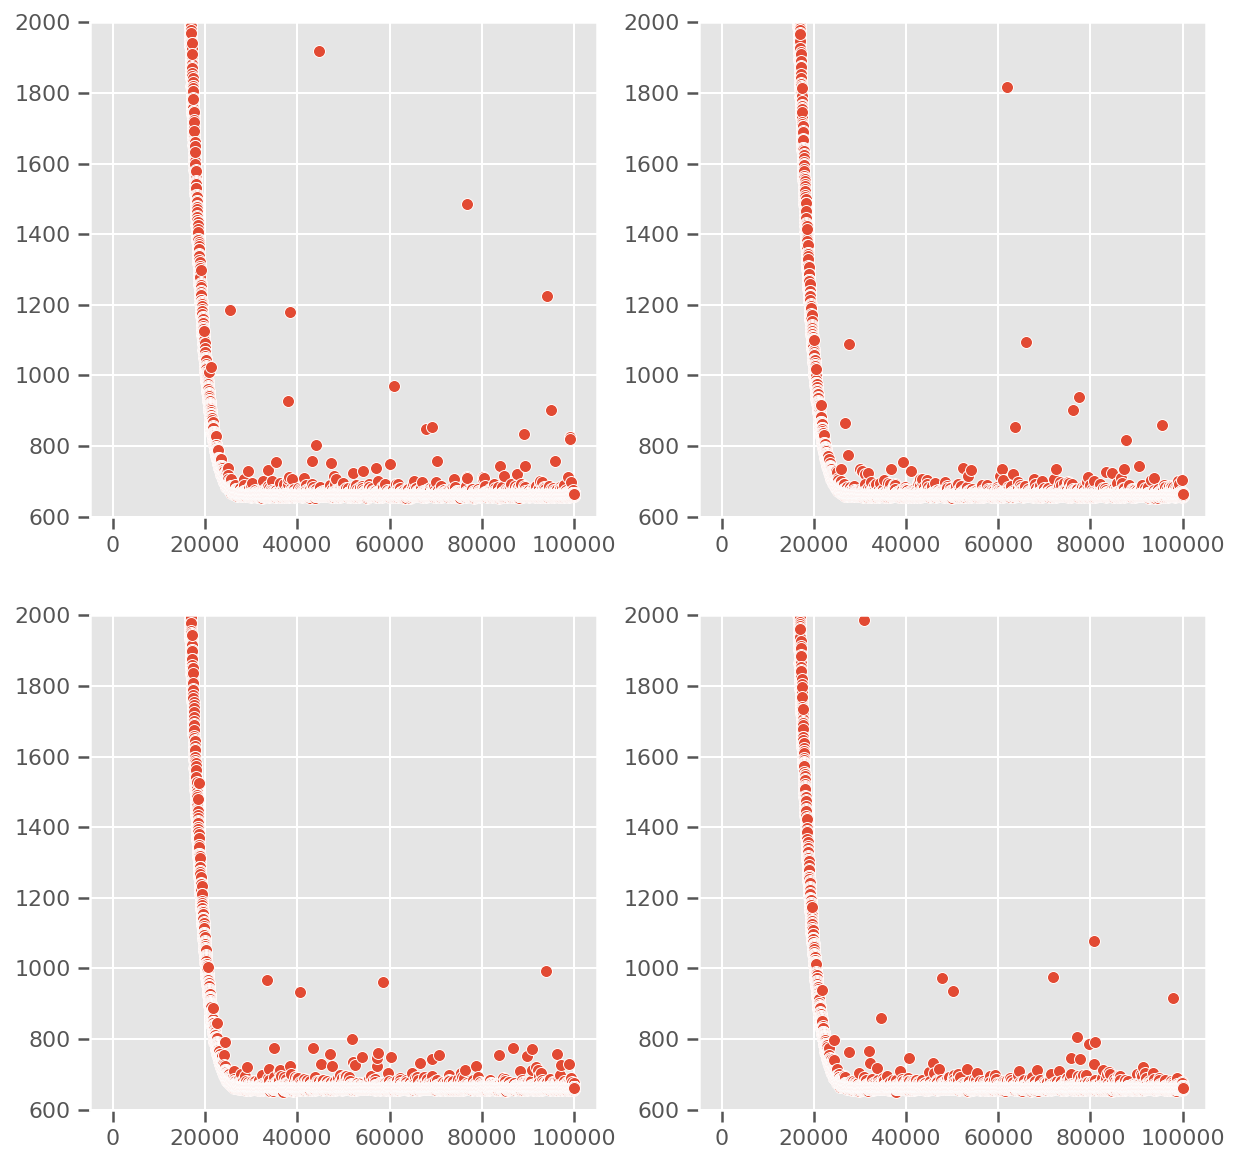

In [ ]:
# don't use this plot, just a quick look at each separate sample in sample_size
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
myplot=sns.scatterplot(ax=axes[0,0],x=list(range(0,100000)),y=myres_loss[:,0])
myplot.set(ylim=(600, 2000))
myplot=sns.scatterplot(ax=axes[0,1],x=list(range(0,100000)),y=myres_loss[:,1])
myplot.set(ylim=(600, 2000))
myplot=sns.scatterplot(ax=axes[1,0],x=list(range(0,100000)),y=myres_loss[:,2])
myplot.set(ylim=(600, 2000))
myplot=sns.scatterplot(ax=axes[1,1],x=list(range(0,100000)),y=myres_loss[:,3])
myplot.set(ylim=(600, 2000))

[Text(0.5, 0, 'Loss')]

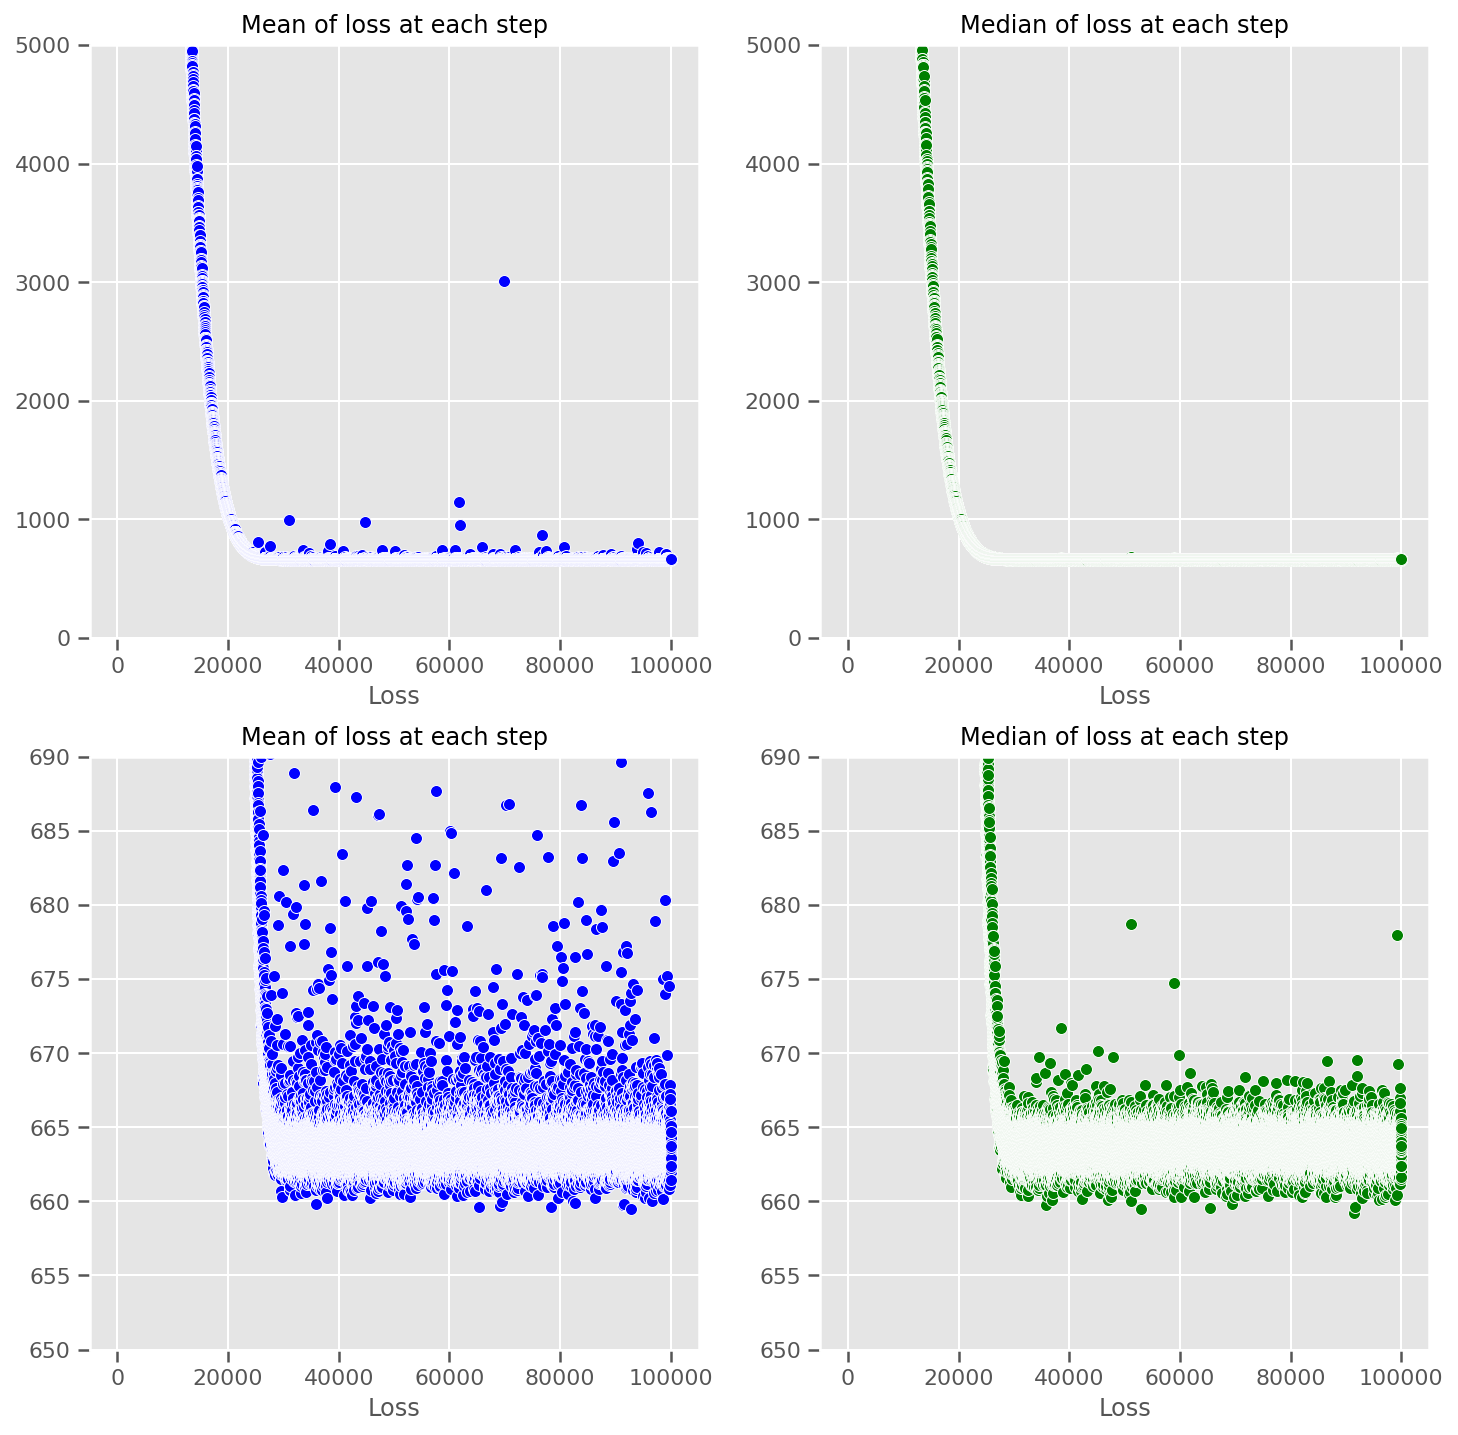

In [ ]:
# look at means and medians of sample_size at each iteration. Better view of the loss evolution
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
myplot=sns.scatterplot(ax=axes[0,0],x=list(range(0,100000)),y=mymean_loss,color='blue')
myplot.set(ylim=(0, 5000))
myplot.set(title="Mean of loss at each step")
myplot.set(xlabel="Iteration")
myplot.set(xlabel="Loss")
myplot=sns.scatterplot(ax=axes[0,1],x=list(range(0,100000)),y=mymedian_loss,color='green')
myplot.set(ylim=(0, 5000))
myplot.set(title="Median of loss at each step")
myplot.set(xlabel="Iteration")
myplot.set(xlabel="Loss")
myplot=sns.scatterplot(ax=axes[1,0],x=list(range(0,100000)),y=mymean_loss,color='blue')
myplot.set(ylim=(650, 690))
myplot.set(title="Mean of loss at each step")
myplot.set(xlabel="Iteration")
myplot.set(xlabel="Loss")
myplot=sns.scatterplot(ax=axes[1,1],x=list(range(0,100000)),y=mymedian_loss,color='green')
myplot.set(ylim=(650, 690))
myplot.set(title="Median of loss at each step")
myplot.set(xlabel="Iteration")
myplot.set(xlabel="Loss")
#plt.savefig('loss.png')
#files.download("loss.png")

### Take a look at the point estimates of the key parameters

In [ ]:
print('        intercept (mean): ', tf.reduce_mean(myres['alpha_i']))
print('            slope (mean): ', tf.reduce_mean(myres['beta_i']))
print('            scale (mean): ', tf.reduce_mean(myres['tau_c']))
print(f'\n')
print('        intercept (sd): ', np.std(myres['alpha_i']))
print('            slope (sd): ', np.std(myres['beta_i']))
print('            scale (sd): ', np.std(myres['tau_c']))

        intercept (mean):  tf.Tensor(106.46048, shape=(), dtype=float32)
            slope (mean):  tf.Tensor(6.2000523, shape=(), dtype=float32)
            scale (mean):  tf.Tensor(16.21173, shape=(), dtype=float32)


        intercept (sd):  1.3867471
            slope (sd):  0.052250218
            scale (sd):  0.9528361


### Now for some density plots, marginal posterior densities

In [ ]:
# create data set of posterior parameter for plotting densities
myres_df = pd.DataFrame({'alpha_i' : np.reshape(myres['alpha_i'],(-1,),'C'),
                   'beta_i': np.reshape(myres['beta_i'],(-1,),'C'),
                   'tau_c': np.reshape(myres['tau_c'],(-1,),'C')})

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

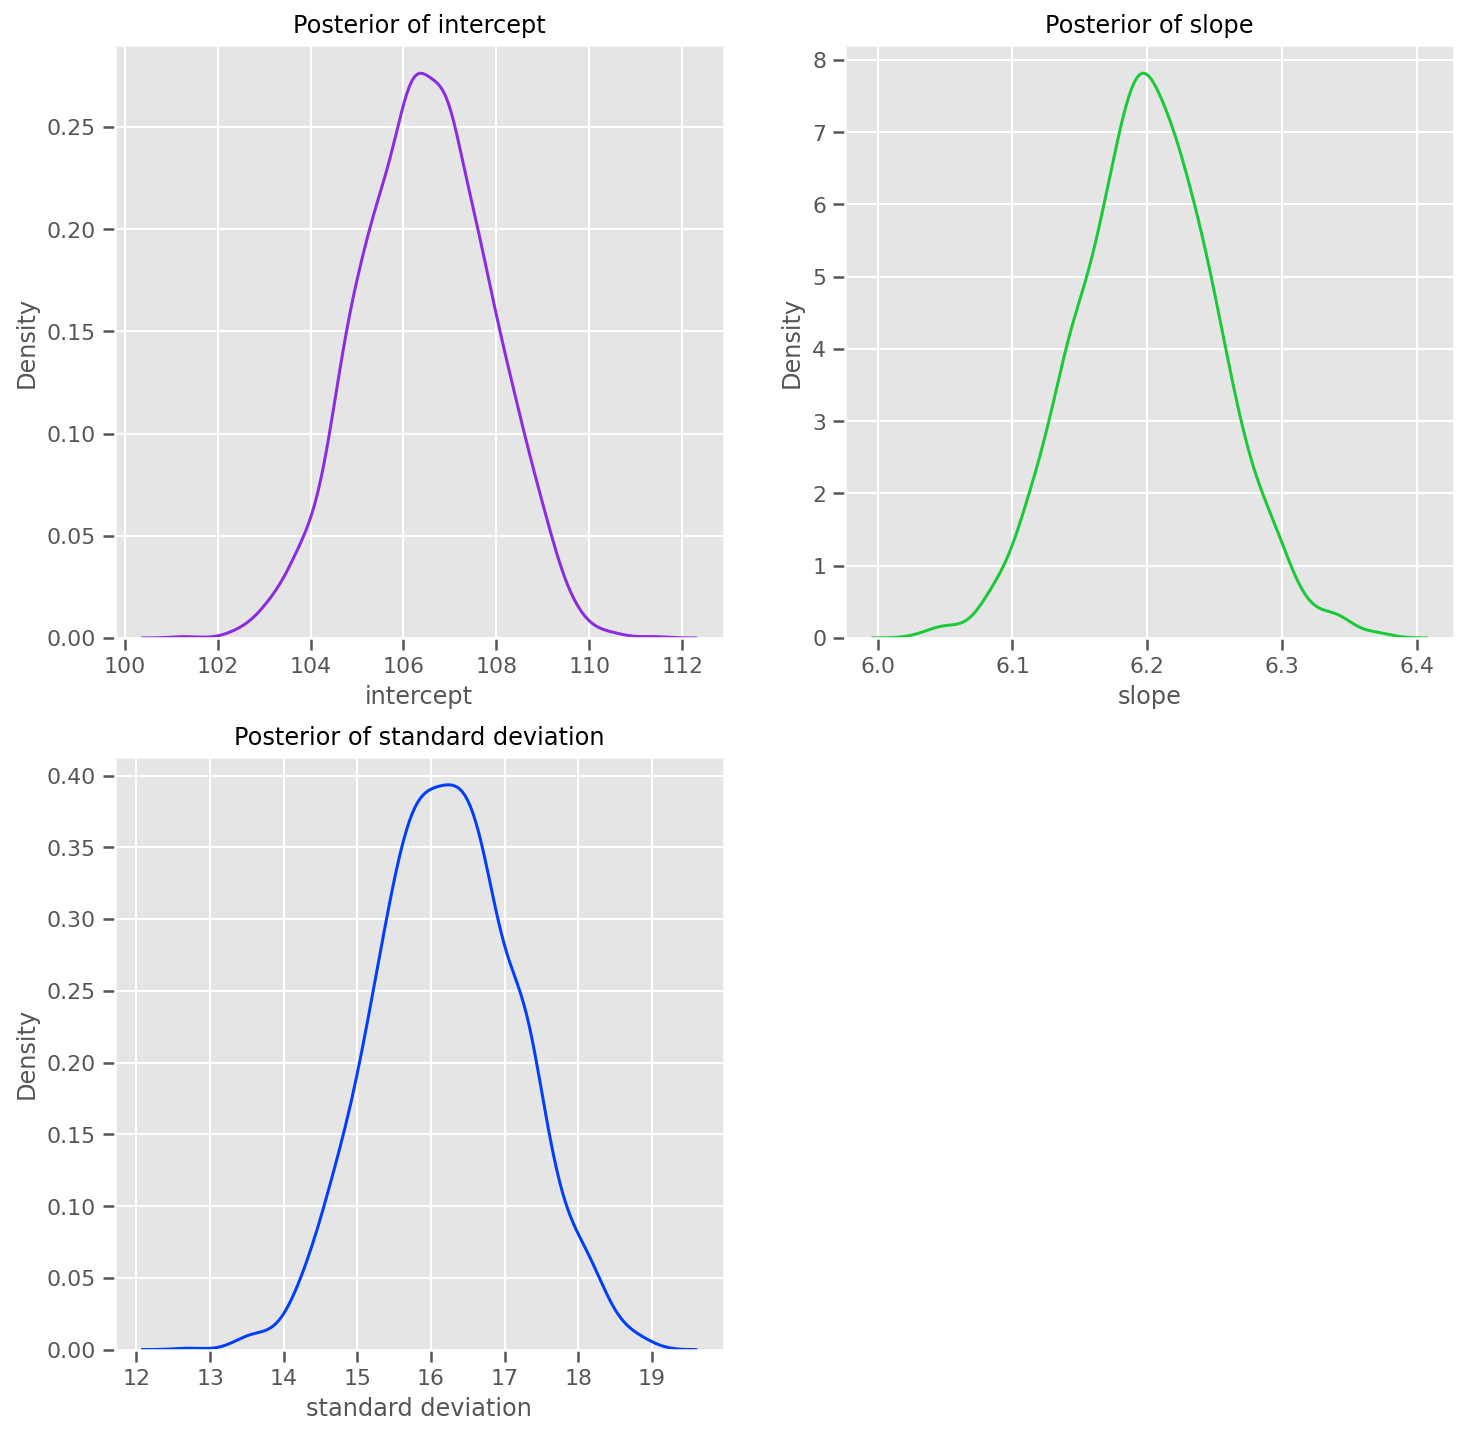

In [ ]:
sns.set_color_codes("bright") # deep, muted, pastel, dark, bright, colorblind
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
myplot=sns.kdeplot(ax=axes[0,0],x='alpha_i',data=myres_df,color='m')
myplot.set(xlabel='intercept')
myplot.set(title="Posterior of intercept")
myplot=sns.kdeplot(ax=axes[0,1],x='beta_i',data=myres_df,color='g')
myplot.set(xlabel='slope')
myplot.set(title="Posterior of slope")
myplot=sns.kdeplot(ax=axes[1,0],x='tau_c',data=myres_df,color='b')
myplot.set(xlabel='standard deviation')
myplot.set(title="Posterior of standard deviation")
fig.delaxes(axes[1,1])
plt.savefig('marg.png')
files.download("marg.png")

---
# END OF PART 1
---

# Bijector designed surrogate posterior
Repeat above analyses 

In [ ]:
# Determine the `event_shape` of the posterior, and calculate the size of each
# `event_shape` component. These determine the sizes of the components of the
# underlying standard Normal distribution, and the dimensions of the blocks in
# the blockwise matrix transformation.
event_shape = target_model1.event_shape_tensor()
flat_event_shape = tf.nest.flatten(event_shape)
flat_event_size = tf.nest.map_structure(tf.reduce_prod, flat_event_shape)

# The `event_space_bijector` maps unconstrained values (in R^n) to the support
# of the prior -- we'll need this at the end to constrain Multivariate Normal
# samples to the prior's support.
event_space_bijector = target_model1.experimental_default_event_space_bijector()

In [ ]:
#print(flat_event_size)
#print(flat_event_shape)

In [ ]:
base_standard_dist = tfd.JointDistributionSequential(
      [tfd.Sample(tfd.Normal(0., 1.), s) for s in flat_event_size])

In [ ]:
#'alpha_c': tfd.Normal(loc=0.,scale=np.sqrt(100).astype('float32')),
#  'beta_c': tfd.Normal(loc=0.,scale=np.sqrt(100).astype('float32')),
#  'tau_alpha': tfd.HalfNormal(scale=10),
#  'tau_beta': tfd.HalfNormal(scale=10),
#  'tau_c': tfd.HalfNormal(scale=10),
#  'alpha_i' : lambda alpha_c, tau_alpha: tfd.Normal(loc=alpha_c,scale=tau_alpha),
#  'beta_i':  lambda beta_c, tau_beta: tfd.Normal(loc=beta_c,scale=tau_beta),

# alpha_c
# cov(beta_c,alpha_c) beta_c
# cov(tau_alpha,alpha_c) cov(tau_alpha,beta_c) tau_alpha
# cov(tau_beta,alpha_c) cov(tau_beta,beta_c) cov(tau_beta,tau_alpha) tau_beta
# cov(tau_c,alpha_c) cov(tau_c,beta_c) cov(tau_c,tau_alpha) cov(tau_c,tau_beta) tau_c
# cov(alpha_i,alpha_c) cov(alpha_i,beta_c) cov(alpha_i,tau_alpha) cov(alpha_i,tau_beta) cov(alpha_i,tau_c) alpha_i
# cov(beta_i,alpha_c) cov(beta_i,beta_c) cov(beta_i,tau_alpha) cov(beta_i,tau_beta) cov(beta_i,tau_c) cov(beta_i,alpha_i) beta_i

## define covariance matrix - lower triangular - see API. This is quite complex.
operators = (
    (tf.linalg.LinearOperatorDiag,),                                    # alpha_c
    (None, tf.linalg.LinearOperatorDiag),                               # beta_c
    (None,  None,  tf.linalg.LinearOperatorDiag),                       # tau_alpha
    (None,  None, None, tf.linalg.LinearOperatorDiag),                  # tau_beta
    (None,  None, None, None, tf.linalg.LinearOperatorDiag),            # tau_c
    (None,  None, None, None, None, tf.linalg.LinearOperatorDiag),      # alpha_i
    (None,  None, None, None, None, None, tf.linalg.LinearOperatorDiag) # beta_i
    )

block_tril_linop = (
    tfp.experimental.vi.util.build_trainable_linear_operator_block(
        operators, flat_event_size))
scale_bijector = tfb.ScaleMatvecLinearOperatorBlock(block_tril_linop)

In [ ]:
loc_bijector = tfb.JointMap(
    tf.nest.map_structure(
        lambda s: tfb.Shift(
            tf.Variable(tf.random.uniform(
                (s,), minval=-2., maxval=2., dtype=tf.float32))),
        flat_event_size))

In [ ]:
# Reshape each component to match the prior, using a nested structure of
# `Reshape` bijectors wrapped in `JointMap` to form a multipart bijector.
reshape_bijector = tfb.JointMap(
    tf.nest.map_structure(tfb.Reshape, flat_event_shape))

# Restructure the flat list of components to match the prior's structure
unflatten_bijector = tfb.Restructure(
        tf.nest.pack_sequence_as(
            event_shape, range(len(flat_event_shape))))

In [ ]:
surrogate_posterior_bi = tfd.TransformedDistribution(
    base_standard_dist,
    bijector = tfb.Chain(  # Note that the chained bijectors are applied in reverse order
        [
         event_space_bijector,  # constrain the surrogate to the support of the prior
         unflatten_bijector,  # pack the reshaped components into the `event_shape` structure of the posterior
         reshape_bijector,  # reshape the vector-valued components to match the shapes of the posterior components
         loc_bijector,  # allow for nonzero mean
         scale_bijector  # apply the block matrix transformation to the standard Normal distribution
         ]))

In [ ]:
optimizer_bi = tf.optimizers.Adam(learning_rate=1e-2)

@tf.function(jit_compile=True)
def fit_vi_bi():
  return tfp.vi.fit_surrogate_posterior(
      target_model1.unnormalized_log_prob,
      surrogate_posterior_bi,
      optimizer=optimizer_bi,
      num_steps=100000,
      sample_size=4, # note the shape of myloss is not 4 so something different happens when using bijector formulation
      )
myres_loss_bi = fit_vi_bi()


/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/internal/vectorization_util.py:97: UserWarning: Saw Tensor seed Tensor("monte_carlo_variational_loss/expectation/JointDistributionNamedAutoBatched/unnormalized_log_prob/Const:0", shape=(2,), dtype=int32), implying stateless sampling. Autovectorized functions that use stateless sampling may be quite slow because the current implementation falls back to an explicit loop. This will be fixed in the future. For now, you will likely see better performance from stateful sampling, which you can invoke by passing a Python `int` seed.
  'by passing a Python `int` seed.'.format(seed))
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/internal/vectorization_util.py:97: UserWarning: Saw Tensor seed Tensor("monte_carlo_variational_loss/expectation/JointDistributionNamedAutoBatched/unnormalized_log_prob/Const:0", shape=(2,), dtype=int32), implying stateless sampling. Autovectorized functions that use stateless sam

### Estimate the ELBO

In [ ]:
myres_bi = surrogate_posterior_bi.sample(2000)

myres_bi_final_elbo = tf.reduce_mean(
    target_model1.unnormalized_log_prob(myres_bi)
    - surrogate_posterior_bi.log_prob(myres_bi))

f'ELBO={myres_bi_final_elbo}\n'

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/internal/vectorization_util.py:97: UserWarning: Saw Tensor seed [0 0], implying stateless sampling. Autovectorized functions that use stateless sampling may be quite slow because the current implementation falls back to an explicit loop. This will be fixed in the future. For now, you will likely see better performance from stateful sampling, which you can invoke by passing a Python `int` seed.
  'by passing a Python `int` seed.'.format(seed))


'ELBO=-663.8926391601562\n'

In [ ]:
myres_loss_bi # note different shape from above - not 4 dimensions

<tf.Tensor: shape=(100000,), dtype=float32, numpy=
array([5.018707e+06, 4.926203e+06, 4.909485e+06, ..., 6.644863e+02,
       6.653778e+02, 6.642942e+02], dtype=float32)>

[Text(0.5, 0, 'Loss')]

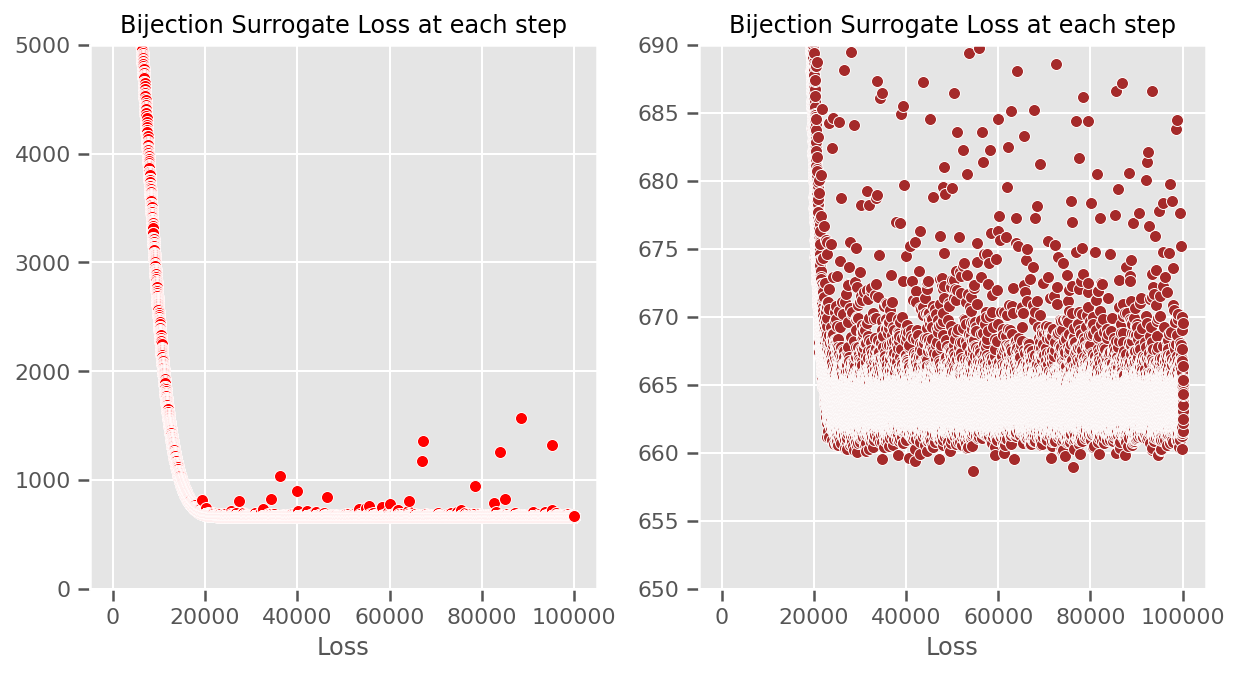

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
myplot=sns.scatterplot(ax=axes[0],x=list(range(0,100000)),y=myres_loss_bi,color='red')
myplot.set(ylim=(0, 5000))
myplot.set(title="Bijection Surrogate Loss at each step")
myplot.set(xlabel="Iteration")
myplot.set(xlabel="Loss")
myplot=sns.scatterplot(ax=axes[1],x=list(range(0,100000)),y=myres_loss_bi,color='brown')
myplot.set(ylim=(650, 690))
myplot.set(title="Bijection Surrogate Loss at each step")
myplot.set(xlabel="Iteration")
myplot.set(xlabel="Loss")
#plt.savefig('bi.png')
#files.download("bi.png")

In [ ]:
print('        intercept (mean): ', tf.reduce_mean(myres_bi['alpha_i']))
print('            slope (mean): ', tf.reduce_mean(myres_bi['beta_i']))
print('    scale (approx. mean): ', tf.reduce_mean(myres_bi['tau_c']))
print()
print(f'intercept (sd): {np.std(myres_bi["alpha_i"])}')
print(f'    slope (sd): {np.std(myres_bi["beta_i"])}')
print(f'    scale (sd): {np.std(myres_bi["tau_c"])}')

        intercept (mean):  tf.Tensor(106.43537, shape=(), dtype=float32)
            slope (mean):  tf.Tensor(6.1567698, shape=(), dtype=float32)
    scale (approx. mean):  tf.Tensor(16.270014, shape=(), dtype=float32)

intercept (sd): 1.3222635984420776
    slope (sd): 0.046938758343458176
    scale (sd): 0.8593549132347107


Numerical results above are almost identical to those from the previous surrogate as should be the case

In [ ]:
myres_bi_df = pd.DataFrame({'alpha_i' : np.reshape(myres_bi['alpha_i'],(-1,),'C'),
                   'beta_i': np.reshape(myres_bi['beta_i'],(-1,),'C'),
                   'tau_c': np.reshape(myres_bi['tau_c'],(-1,),'C')})

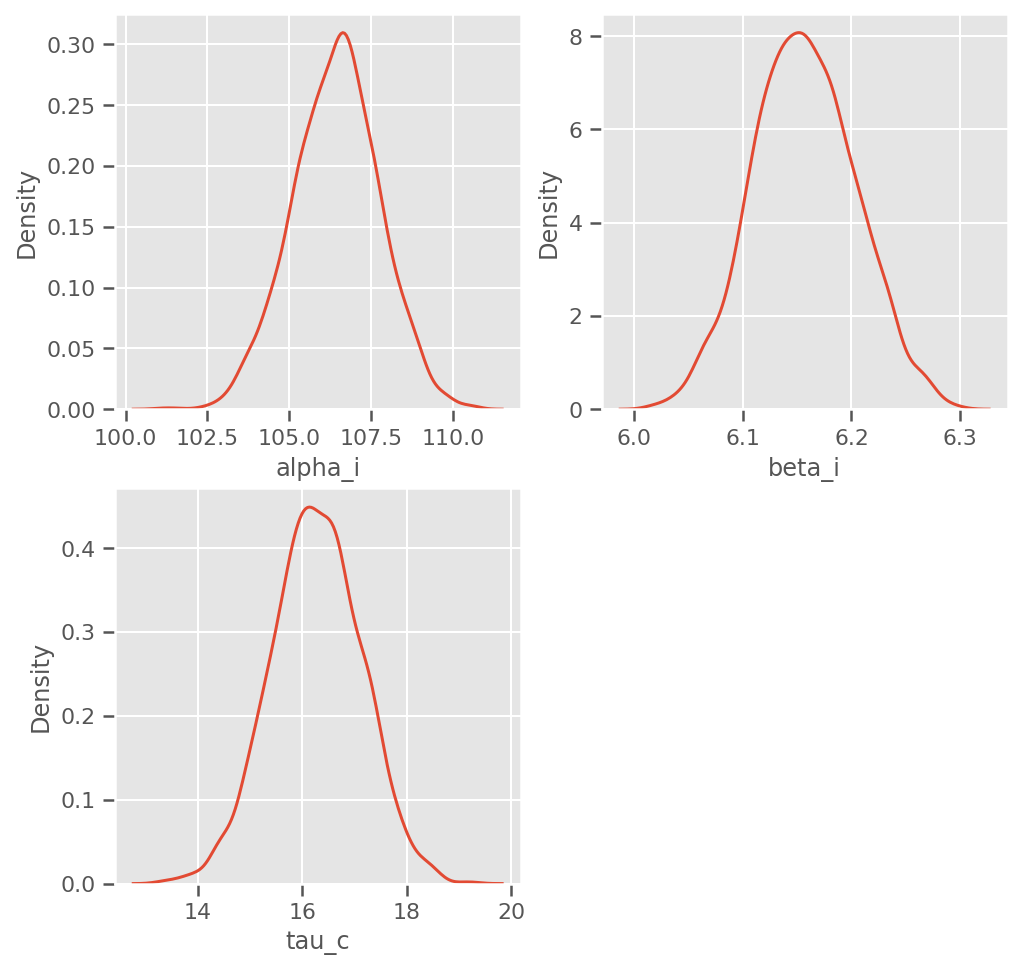

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
sns.kdeplot(ax=axes[0,0],x='alpha_i',data=myres_bi_df)
sns.kdeplot(ax=axes[0,1],x='beta_i',data=myres_bi_df)
sns.kdeplot(ax=axes[1,0],x='tau_c',data=myres_bi_df)
fig.delaxes(axes[1,1])

---
# END OF PART 2
---

# PART 3 Normalizing Flows

In [ ]:
# Build a standard Normal with a vector `event_shape`, with length equal to the
# total number of degrees of freedom in the posterior.
base_distribution = tfd.Sample(
    tfd.Normal(0., 1.), sample_shape=[tf.reduce_sum(flat_event_size)])

# Apply an IAF to the base distribution.
num_iafs = 2
iaf_bijectors = [
    tfb.Invert(tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
            params=2, hidden_units=[2,2],activation='relu'))) # 2,2 linear is as good as anything
    for _ in range(num_iafs)
]

# Split the base distribution's `event_shape` into components that are equal
# in size to the prior's components.
split = tfb.Split(flat_event_size)

# Chain these bijectors and apply them to the standard Normal base distribution
# to build the surrogate posterior. `event_space_bijector`,
# `unflatten_bijector`, and `reshape_bijector` are the same as in the
# multivariate Normal surrogate posterior.
iaf_surrogate_posterior = tfd.TransformedDistribution(
    base_distribution,
    bijector=tfb.Chain([
         event_space_bijector,  # constrain the surrogate to the support of the prior
         unflatten_bijector,  # pack the reshaped components into the `event_shape` structure of the prior
         reshape_bijector,  # reshape the vector-valued components to match the shapes of the prior components
         split] +  # Split the samples into components of the same size as the prior components
         iaf_bijectors  # Apply a flow model to the Tensor-valued standard Normal distribution
         ))

In [ ]:
optimizer_iaf1 = tf.optimizers.Adam(learning_rate=1e-3)
#for var in optimizer2.variables():
#    var.assign(tf.zeros_like(var))

@tf.function(jit_compile=True)
def fit_vi():
  return tfp.vi.fit_surrogate_posterior(
      target_model1.unnormalized_log_prob,
      iaf_surrogate_posterior,
      optimizer=optimizer_iaf1,
      num_steps=200000,
      sample_size=1,# using a higher number here results in all nan - not stable
      )
iaf_loss = fit_vi()

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/internal/vectorization_util.py:97: UserWarning: Saw Tensor seed Tensor("monte_carlo_variational_loss/expectation/JointDistributionNamedAutoBatched/unnormalized_log_prob/Const:0", shape=(2,), dtype=int32), implying stateless sampling. Autovectorized functions that use stateless sampling may be quite slow because the current implementation falls back to an explicit loop. This will be fixed in the future. For now, you will likely see better performance from stateful sampling, which you can invoke by passing a Python `int` seed.
  'by passing a Python `int` seed.'.format(seed))
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/internal/vectorization_util.py:97: UserWarning: Saw Tensor seed Tensor("monte_carlo_variational_loss/expectation/JointDistributionNamedAutoBatched/unnormalized_log_prob/Const:0", shape=(2,), dtype=int32), implying stateless sampling. Autovectorized functions that use stateless sam

In [ ]:
iaf_loss

<tf.Tensor: shape=(200000,), dtype=float32, numpy=
array([3.7899568e+07, 1.3964152e+06, 4.4352440e+06, ..., 6.6379675e+02,
       6.6569421e+02, 6.6163098e+02], dtype=float32)>

[Text(0.5, 0, 'Loss')]

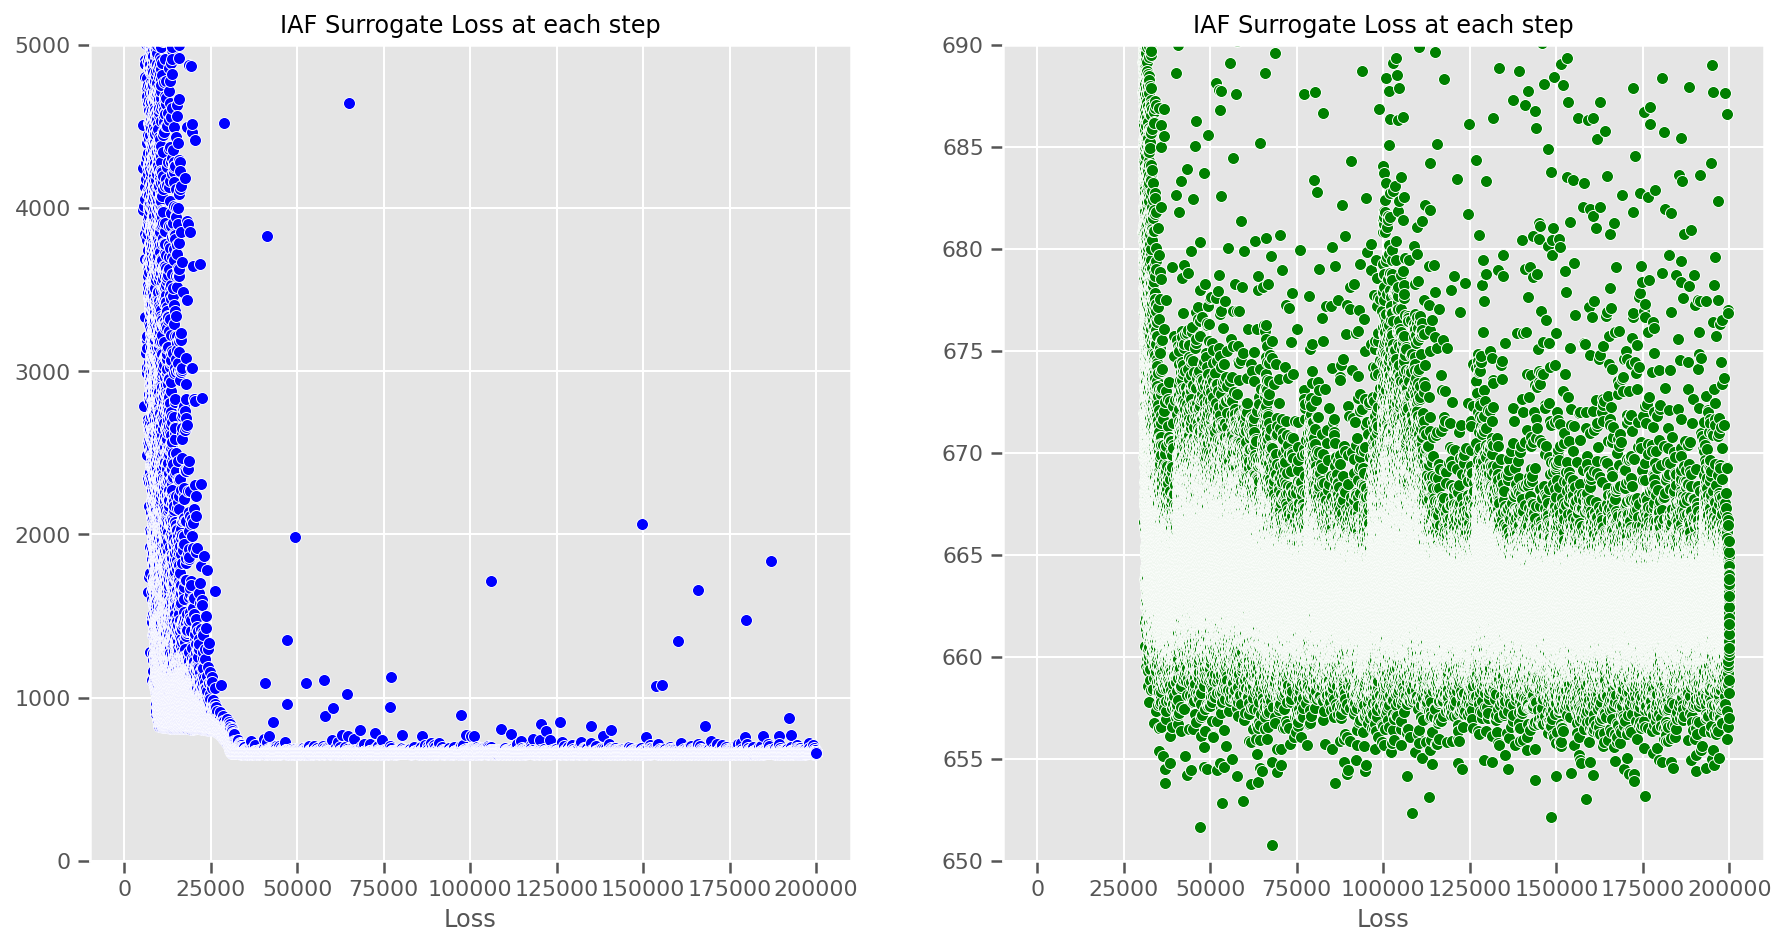

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7.5))
myplot=sns.scatterplot(ax=axes[0],x=list(range(0,200000)),y=iaf_loss,color='blue')
myplot.set(ylim=(0, 5000))
myplot.set(title="IAF Surrogate Loss at each step")
myplot.set(xlabel="Iteration")
myplot.set(xlabel="Loss")
myplot=sns.scatterplot(ax=axes[1],x=list(range(0,200000)),y=iaf_loss,color='green')
myplot.set(ylim=(650, 690))
myplot.set(title="IAF Surrogate Loss at each step")
myplot.set(xlabel="Iteration")
myplot.set(xlabel="Loss")
#plt.savefig('iaf.png')
#files.download("iaf.png")

### Estimate the ELBO

In [ ]:
iaf_samples = iaf_surrogate_posterior.sample(2000)
iaf_final_elbo = tf.reduce_mean(
    target_model1.unnormalized_log_prob(iaf_samples)
    - iaf_surrogate_posterior.log_prob(iaf_samples))
print(iaf_final_elbo)

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/internal/vectorization_util.py:97: UserWarning: Saw Tensor seed [0 0], implying stateless sampling. Autovectorized functions that use stateless sampling may be quite slow because the current implementation falls back to an explicit loop. This will be fixed in the future. For now, you will likely see better performance from stateful sampling, which you can invoke by passing a Python `int` seed.
  'by passing a Python `int` seed.'.format(seed))


tf.Tensor(-662.69354, shape=(), dtype=float32)


In [ ]:
print('        intercept (mean): ', tf.reduce_mean(iaf_samples['alpha_i']))
print('     floor_weight (mean): ', tf.reduce_mean(iaf_samples['beta_i']))
print(' scale_prior (approx. mean): ', tf.reduce_mean(iaf_samples['tau_c']))
print()
print(f'std alpha_i={np.std(iaf_samples["alpha_i"])}')
print(f'std beta_i={np.std(iaf_samples["beta_i"])}')
print(f'std tau_c={np.std(iaf_samples["tau_c"])}')

        intercept (mean):  tf.Tensor(106.27705, shape=(), dtype=float32)
     floor_weight (mean):  tf.Tensor(6.211501, shape=(), dtype=float32)
 scale_prior (approx. mean):  tf.Tensor(16.229578, shape=(), dtype=float32)

std alpha_i=3.0827088356018066
std beta_i=0.1203884556889534
std tau_c=0.923059344291687


In [ ]:
myres_iaf_df = pd.DataFrame({'alpha_i' : np.reshape(iaf_samples['alpha_i'],(-1,),'C'),
                   'beta_i': np.reshape(iaf_samples['beta_i'],(-1,),'C'),
                   'tau_c': np.reshape(iaf_samples['tau_c'],(-1,),'C')})

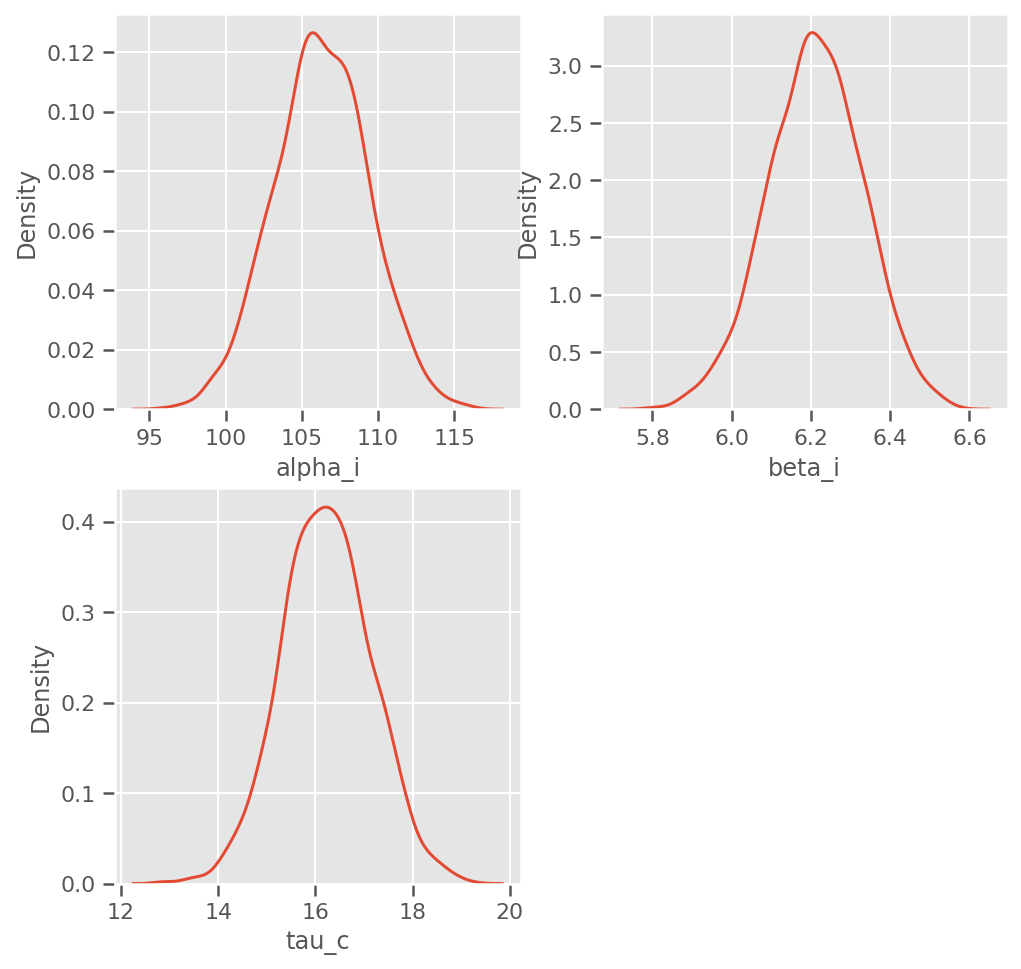

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
sns.kdeplot(ax=axes[0,0],x='alpha_i',data=myres_iaf_df)
sns.kdeplot(ax=axes[0,1],x='beta_i',data=myres_iaf_df)
sns.kdeplot(ax=axes[1,0],x='tau_c',data=myres_iaf_df)
fig.delaxes(axes[1,1])

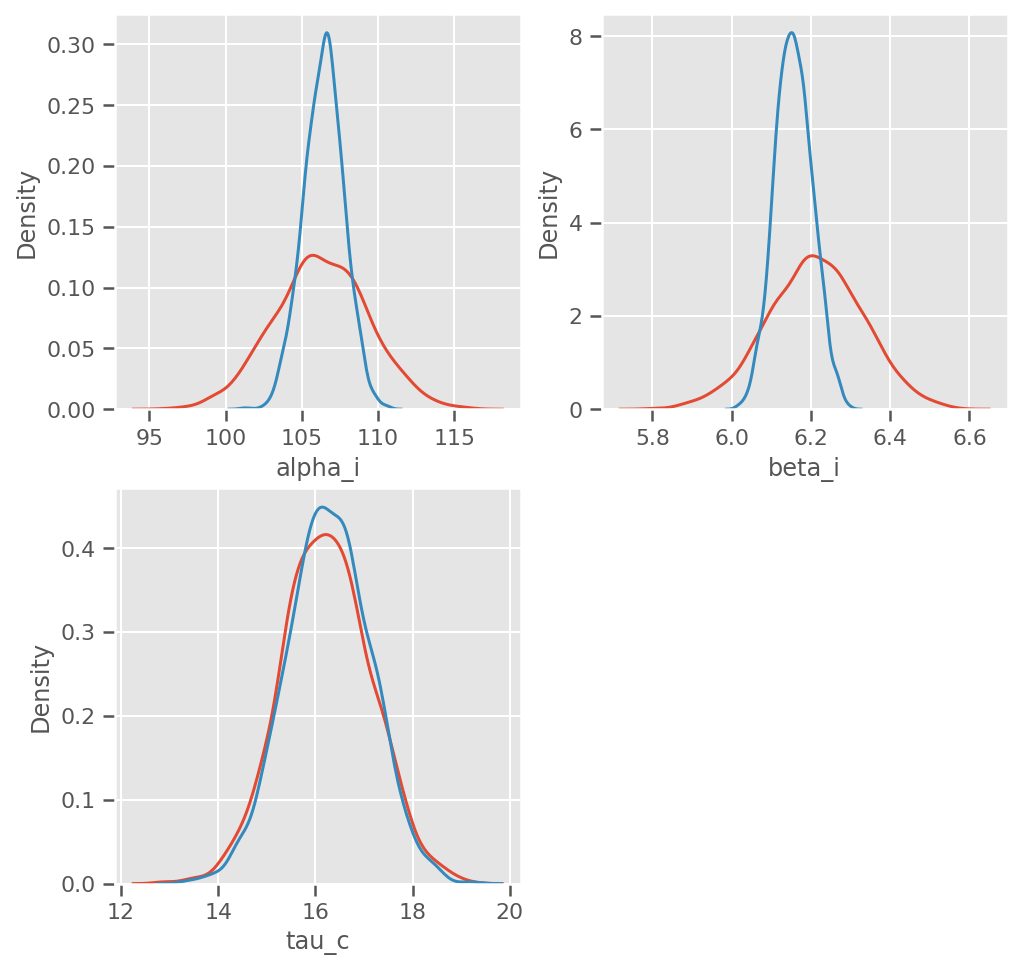

In [ ]:
myres_iaf_df = pd.DataFrame({'alpha_i' : np.reshape(iaf_samples['alpha_i'],(-1,),'C'),
                   'beta_i': np.reshape(iaf_samples['beta_i'],(-1,),'C'),
                   'tau_c': np.reshape(iaf_samples['tau_c'],(-1,),'C')})


fig, axes = plt.subplots(2, 2, figsize=(8, 8))
sns.kdeplot(ax=axes[0,0],x='alpha_i',data=myres_iaf_df)
sns.kdeplot(ax=axes[0,0],x='alpha_i',data=myres_bi)
sns.kdeplot(ax=axes[0,1],x='beta_i',data=myres_iaf_df)
sns.kdeplot(ax=axes[0,1],x='beta_i',data=myres_bi)
sns.kdeplot(ax=axes[1,0],x='tau_c',data=myres_iaf_df)
sns.kdeplot(ax=axes[1,0],x='tau_c',data=myres_bi)
fig.delaxes(axes[1,1])

## JAGS results
These results are hard coded from the jags modeling run elsewhere - see subfolder in repo. These are realizations from the posterior density

In [ ]:
res_jags = pd.DataFrame({'alpha_i' : (109.055,108.217,108.903,107.758,106.56,106.403,106.49,107.253,107.897,106.193,108.42,104.468,103.873,103.842,102.901,106.384,101.89,105.57,107.647,110.392,106.513,108.289,107.515,107.662,101.125,104.434,107.161,103.35,112.622,111.389,108.104,111.361,101.827,100.752,105.079,110.681,113.179,110.042,103.586,109.348,104.837,107.422,107.663,106.483,107.374,106.481,104.564,102.762,112.006,105.414,109.183,109.133,107.111,103.646,111.302,118.423,113.538,109.127,110.296,102.864,96.4261,97.6854,101.367,104.419,104.412,111.421,106.623,107.151,105.853,107.862,106.823,103.673,100.009,101.409,99.7513,106.293,105.596,103.823,103.631,104.401,109.008,106.447,105.733,104.734,109.312,108.981,106.585,101.877,107.815,104.681,111.242,109.388,100.338,102.016,101.665,106.536,105.064,107.179,102.768,107.236,109.21,104.567,107.427,103.65,105.248,106.787,102.802,99.807,102.167,105.118,106.899,105.004,104.139,103.039,108.37,103.003,112.067,101.458,106.349,106.875,106.351,105.727,107.205,106.718,109.185,109.439,109.273,107.767,108.549,105.952,109.71,108.592,107.864,109.042,111.147,109.107,103.248,105.974,106.83,105.463,102.412,102.469,107.27,106.932,111.063,110.154,114.05,111.055,104.947,109.212,108.287,110.511,112.414,110.042,111.166,107.827,109.267,111.577,110.052,108.94,106.549,105.045,105.712,108.459,109.302,109.333,106.623,103.969,101.857,102.949,106.688,108.01,103.529,103.995,101.248,102.325,100.603,102.576,104.91,108.579,108.287,108.94,111.744,113.902,111.899,102.383,105.892,109.848,104.646,107.032,107.154,106.59,106.05,108.641,105.857,105.207,105.207,104.753,105.442,105.308,103.949,99.0808,106.352,107.746,101.462,99.3576,101.226,109.159,113.131,107.177,109.515,103.559,103.188,104.658,102.703,103.86,107.327,107.3,106.961,109.332,112.688,105.862,106.552,103.831,104.709,105.621,107.257,107.126,107.368,105.549,107.66,104.122,100.481,106.115,115.243,114.839,114.814,110.506,105.569,104.746,105.423,108.136,103.31,108.748,105.487,106.188,108.561,113.619,111.614,107.76,105.995,108.952,110.338,102.257,105.982,104.258,108.738,110.372,111.092,112.765,110.829,113.657,107.674,107.154,107.335,105.588,109.7,103.365,110.043,112.212,108.29,111.987,110.048,105.984,107.069,103.243,104.933,105.153,106.228,105.22,101.454,96.7189,105.394,104.445,104.32,105.978,103.327,107.018,107.25,110.87,103.011,103.711,103.538,105.559,106.743,105.72,105.846,111.515,109.394,101.295,103.346,106.792,108.449,105.508,109.064,109.7,108.77,106.718,107.402,107.453,104.876,101.185,99.7167,101.09,103.612,104.35,103.533,105.891,104.858,102.719,101.083,102.526,102.595,99.4576,104.401,109.635,112.603,104.119,104.651,107.436,109.54,108.843,102.026,101.027,101.037,106.114,103.767,106.937,111.346,112.278,108.653,108.625,101.157,106.704,106.26,103.722,102.961,104.499,106.042,106.456,106.162,101.701,103.759,104.316,108.489,112.452,111.098,110.883,103.519,101.584,103.082,108.975,105.936,108.996,109.58,104.005,109.083,112.051,108.453,106.262,106.416,104.247,107.972,107.877,101.627,102.663,104.938,102.763,110.052,106.52,110.506,110.801,108.315,110.718,107.903,110.634,107.963,107.138,105.795,107.145,108.283,105.006,107.731,108.756,110.444,106.854,106.536,102.857,102.227,103.397,102.48,102.226,103.222,103.996,104.241,104.555,107.546,106.211,109.635,109.209,105.568,104.328,110.742,102.788,100.62,101.391,101.305,106.472,107.68,105.632,105.804,105.14,105.858,102.439,107.244,108.932,107.405,107.666,107.536,104.664,111.411,108.002,111.018,111.667,109.566,112.106,105.927,107.6,107.482,111.145,107.719,108.447,107.822,104.177,107.605,104.034,106.709,110.372,109.162,101.655,106.993,100.184,100.877,108.816,111.04,104.826,103.122,106.794,113.293,105.407,104.59,106.78,108.075,105.954,111.076,102.062,102.943,102.872,107.292,95.4732,103.226,102.864,105.387,103.726,106.187,112.754,106.118,105.597,104.725,104.557,102.522,102.262,105.348,104.084,101.588,103.347,104.015,104.843,105.018,104.805,105.56,104.937,104.677,107.267,109.045,109.425,108.875,103.334,106.987,103.192,106.617,109.025,104.118,106.437,110.157,108.787,109.797,107.896,113.261,111.791,109.457,112.903,113.862,108.85,106.611,107.245,105.842,107.241,105.138,109.681,109.432,106.268,108.199,105.948,107.073,103.82,103.461,105.205,110.107,112.775,107.253,106.602,111.417,109.35,101.091,105.261,107.477,107.245,106.462,106.178,106.711,106.659,109.265,111.657,108.745,105.002,105.521,106.69,103.234,107.454,101.151,104.869,109.074,106.49,113.927,107.981,104.395,105.043,105.901,105.854,107.941,108.54,109.757,107.56,106.583,106.81,107.872,102.696,103.337,105.832,105.876,103.948,105.481,110.649,109.042,110.834,105.993,103.644,106.379,107.942,102.678,105.272,110.367,111.125,110.176,106.908,108.267,110.658,102.774,109.898,110.141,112.805,106.376,107.172,101.317,101.177,111.887,101.745,105.196,102.581,102.249,102.32,106.783,104.459,103.081,102.188,108.784,108.888,110.744,106.596,107.133,105.636,110.47,111.121,108.082,109.437,109.562,109.531,107.671,111.955,112.14,105.534,108.596,106.202,108.129,106.592,106.824,114.192,109.239,107.855,104.507,105.52,104.65,104.293,103.92,107.844,103.575,106.869,106.384,105.405,104.224,102.493,106.635,109.191,103.269,105.422,107.258,100.338,104.317,103.926,106.734,105.642,106.351,106.878,105.26,105.66,103.117,102.136,100.126,98.9736,100.449,102.668,98.9261,101.669,104.677,106.139,109.407,106.616,100.407,101.106,105.593,106.789,103.523,109.221,105.772,112.486,112.304,109.83,108.502,105.335,108.243,105.415,105.716,105.959,103.75,99.3115,105.316,108.18,108.458,108.52,101.358,99.4171,99.5565,100.072,100.821,103.997,101.886,104.756,105.24,103.589,103.372,102.457,106.806,110.205,108.234,101.738,105.927,103.091,107.288,107.136,109.489,108.133,106.058,106.192,102.568,107.695,109.607,103.976,106.252,108.193,106.488,106.465,103.538,100.555,101.667,104.059,112.12,111.735,109.971,112.162,106.346,107.265,105.784,108.298,108.023,110.84,106.953,105.583,105.771,103.018,104.394,110.397,107.621,107.155,105.266,106.159,108.168,102.877,108.56,106.201,105.064,103.497,109.811,106.341,108.493,108.269,108.12,108.49,105.23,105.354,103.476,104.326,105.044,105.857,101.241,101.05,105.241,111.5,107.742,110.966,113.07,107.797,103.761,103.847,103.103,108.102,105.925,108.105,107.14,103.179,103.914,103.997,109.334,110.676,109.582,108.928,109.786,104.814,103.751,102.425,103.15,104.771,104.151,105.468,105.131,106.217,106.337,104.331,106.716,106.991,108.065,109.879,108.045,106.702,109.186,109.832,110.897,110.488,108.078,110.437,107.397,110.469,108.691,107.313,108.858,106.752,104.993,108.935,109.949,107.831,109.675,112.179,111.892,106.537,109.237,103.785,105.335,105.666,104.922,101.965,102.548,103.99,101.891,104.116,104.357,103.939,106.021,103.198,107.011,106.306,109.294,108.127,108.642,106.838,103.373,105.084,106.902,104.57,104.464,103.232,104.366,105.323,107.737,110.109,107.288,111.723,104.48,103.615,104.228,110.997,107.353,104.928,106.344,108.548,108.428,104.567,105.989,107.698,105.85,107.044,107.614,106.991,106.176,106.744,107.677,108.169,110.974,112.087,109.478,109.88,110.216,107.787,102.702,101.656,111.737,111.381,103.905,101.759,105.415,102.956,109.691,107.077,99.9828,104.504,106.501,106.647,105.645,104.578,106.321,107.772,103.135,104.497,107.211,110.311,102.073,106.959,105.272,109.157,106.831,106.094,104.101,104.647,105.307,105.217,104.858,103.97,104.1,100.951,102.135,109.284,108.188,105.218,103.2,103.762,100.135,106.606,107.203,109.148,107.331,103.532,107.392,103.561,106.33,109.704,109.801,110.318,109.525,99.0439,104.219,105.769,106.45,106.519,108.786,109.351,102.988,104.182,106.174,107.029,107.641,113.194,107.493,107.581,109.232,113.599,112.388,106.823,101.704,101.304,106.967,103.892,103.616,101.492,104.329,99.3262,96.971,106.288,108.056,107.734,105.422,103.611,107.067,105.596,110.493,109.998,109.353,111.583,111.449,111.035,110.892,108.462,106.805,102.447,107.37,106.468,106.953,105.578,109.03,106.868,103.689,107.077,105.551,104.225,104.164,107.736,105.354,101.735,107.627,107.468,100.775,101.366),
                         'beta_i' : (6.08758,6.33076,6.13253,6.12544,6.23347,6.14338,6.13444,6.21464,6.08677,6.19824,6.01509,6.23093,6.28734,6.29281,6.32036,6.16025,6.31704,6.25605,6.1131,5.99339,6.15758,6.11893,6.14559,6.11139,6.41933,6.31225,6.11958,6.32838,5.99977,6.03771,6.03009,6.08825,6.30533,6.46126,6.32145,5.9893,5.94918,6.02769,6.26686,6.1146,6.25116,6.27496,6.10281,6.20101,6.22409,6.16873,6.20824,6.43176,5.95894,6.20385,6.1261,6.1366,6.18034,6.24587,5.96628,5.78491,5.91096,6.162,6.05541,6.37799,6.55041,6.51887,6.42059,6.2769,6.261,6.08304,6.18721,6.24008,6.22021,6.20148,6.2353,6.23246,6.36629,6.36783,6.39881,6.20711,6.28213,6.3198,6.19559,6.2416,6.06502,6.18927,6.25623,6.22265,6.14736,6.16119,6.25834,6.38079,6.13758,6.26548,6.01274,6.10887,6.3645,6.34289,6.37621,6.22917,6.36788,6.17106,6.44307,6.19926,6.06892,6.29778,6.12258,6.24625,6.14205,6.18256,6.38985,6.4746,6.31003,6.2367,6.21398,6.16026,6.25085,6.35893,6.08954,6.28052,5.95882,6.41153,6.14942,6.19909,6.13329,6.22552,6.19792,6.16909,6.1307,6.07047,6.10372,6.11172,6.15997,6.22899,6.03188,6.04861,6.13436,6.1827,5.97488,6.08183,6.30131,6.32219,6.18116,6.18742,6.25314,6.26753,6.03415,6.09451,6.02944,6.02568,5.90643,6.04238,6.24193,5.96023,6.07351,6.06554,5.93374,6.01362,5.99412,6.12279,6.0185,6.05793,6.0688,6.13963,6.20437,6.19619,6.18286,6.13619,6.0823,6.00665,6.18367,6.27304,6.42003,6.3161,6.14888,6.11201,6.29331,6.20217,6.34729,6.27914,6.45053,6.31831,6.21228,6.1177,6.07303,6.03175,5.94821,5.90047,5.96846,6.34144,6.22511,5.95199,6.16583,6.22945,6.1108,6.23201,6.11486,6.10431,6.20563,6.30999,6.23824,6.25335,6.23205,6.28017,6.30257,6.44909,6.17271,6.1487,6.38545,6.56771,6.33957,6.1156,6.02834,6.19229,6.09214,6.18798,6.2595,6.20915,6.45149,6.20768,6.14054,6.18616,6.25034,6.10668,6.07849,6.12294,6.18109,6.26134,6.20045,6.24685,6.13094,6.25926,6.17116,6.22924,6.15833,6.25908,6.4249,6.20194,5.8729,5.86413,5.90072,6.02096,6.34381,6.18669,6.24533,6.12712,6.34164,6.08391,6.20003,6.22129,6.09992,5.87253,6.0008,6.16363,6.17178,5.98891,6.088,6.3513,6.37848,6.28645,6.08939,6.02335,6.00608,5.95564,6.07835,5.97884,6.28056,6.21676,6.1132,6.25576,6.01741,6.32205,6.03148,5.96444,6.11372,6.0387,6.08217,6.20645,6.2147,6.35065,6.27913,6.24567,6.17704,6.23666,6.35901,6.53415,6.30989,6.23566,6.28745,6.25607,6.33881,6.20582,6.16444,6.03122,6.20625,6.22552,6.26969,6.38058,6.07362,6.28439,6.19866,5.98596,6.08684,6.41418,6.33272,6.08862,6.07638,6.24015,6.08022,6.0512,6.06626,6.2421,6.2047,6.12517,6.27707,6.3844,6.41275,6.38635,6.24712,6.26933,6.28803,6.17624,6.24647,6.31424,6.35159,6.34626,6.31097,6.40186,6.32743,6.03856,5.89665,6.36298,6.23977,6.12016,6.22216,6.10571,6.28334,6.45807,6.3661,6.20069,6.15151,6.2053,6.05863,6.02924,6.09774,6.13432,6.37999,6.30283,6.1918,6.33942,6.26104,6.26693,6.25177,6.25548,6.22084,6.36409,6.26621,6.17171,6.03899,5.9231,6.09445,5.93747,6.32297,6.40385,6.24919,5.97318,6.14565,6.0483,5.94156,6.27467,6.10782,5.98767,6.10662,6.17764,6.15608,6.31127,6.15148,6.13154,6.34268,6.30468,6.20026,6.34348,6.03309,6.13577,5.94204,6.03883,6.24973,5.97482,6.09951,6.09976,6.12334,6.11095,6.20954,6.22345,6.1233,6.26792,6.14947,6.13617,6.03417,6.08449,6.26463,6.35075,6.42627,6.34625,6.3002,6.32397,6.29863,6.30891,6.40627,6.32224,6.22124,6.26189,5.99054,6.12594,6.2497,6.19072,5.97241,6.38944,6.33632,6.35086,6.37734,6.09448,6.06231,6.22001,6.16472,6.18905,6.24845,6.30067,6.12624,6.1465,6.04936,6.19826,6.09586,6.22333,6.02641,6.09041,6.07315,6.05121,6.09429,5.94826,6.1689,6.17174,6.11252,5.98153,6.08254,6.17261,6.08645,6.19112,6.18333,6.30044,6.05955,6.06345,6.1298,6.35007,6.17158,6.44882,6.33971,6.04212,6.05305,6.25094,6.41177,6.26309,5.84887,6.32675,6.26364,6.23451,6.13178,6.13589,6.01883,6.38904,6.28989,6.27234,6.11625,6.53297,6.27014,6.36045,6.17042,6.27207,6.24851,5.92353,6.22289,6.26505,6.28554,6.27224,6.33347,6.24074,6.27992,6.35277,6.35256,6.34359,6.3004,6.23933,6.22168,6.20655,6.25863,6.21735,6.26184,6.10113,6.18435,6.12503,6.045,6.30646,6.14805,6.3485,6.25129,6.14573,6.19129,6.17547,6.04228,6.02455,6.06464,6.1429,5.92194,5.95684,6.10056,5.88659,5.96647,6.01608,6.1698,6.14993,6.17548,6.30366,6.16798,6.02936,6.14342,6.1631,6.08216,6.19643,6.16026,6.26149,6.31996,6.20736,6.05648,5.97127,6.12688,6.24497,5.95188,6.15427,6.47222,6.20881,6.17939,6.05645,6.2659,6.1914,6.19521,6.26265,6.0464,6.00255,6.12636,6.21846,6.22875,6.20995,6.33863,6.13514,6.43113,6.20236,5.99718,6.16013,5.88603,6.21678,6.33439,6.28588,6.26376,6.19854,6.11816,6.02962,5.97685,6.13365,6.25197,6.23228,6.02231,6.35386,6.25842,6.33454,6.18982,6.34176,6.22907,6.00103,6.038,5.98148,6.18811,6.33863,6.22461,6.1644,6.34136,6.14487,6.12011,6.05974,6.10203,6.10703,6.11891,6.08653,6.27128,6.07558,6.00629,5.90087,6.22371,6.1297,6.41427,6.31443,5.97638,6.41081,6.31462,6.39445,6.4232,6.33229,6.24807,6.23331,6.35749,6.33954,6.11031,6.1653,6.02519,6.16829,6.184,6.1771,6.09492,6.06758,6.19922,6.13493,6.01552,6.05891,6.16592,5.94291,5.97237,6.19573,6.17305,6.05856,6.17921,6.12175,6.16874,5.89518,6.1426,6.12587,6.25385,6.24194,6.22374,6.3233,6.36696,6.10028,6.28814,6.22587,6.23012,6.14305,6.32789,6.30113,6.27619,6.27745,6.32361,6.34412,6.07737,6.38828,6.27693,6.22035,6.20012,6.2361,6.09,6.16752,6.25291,6.23918,6.24192,6.24827,6.39159,6.39611,6.47617,6.39998,6.50864,6.36699,6.23383,6.1719,6.08638,6.19356,6.43607,6.4213,6.16684,6.22394,6.33094,6.11329,6.17479,5.97904,5.86387,6.13229,6.07025,6.27216,6.16108,6.20637,6.18229,6.12929,6.2424,6.33661,6.31441,6.06778,6.10486,6.16608,6.47129,6.47782,6.45917,6.45436,6.47295,6.43076,6.39431,6.34511,6.24216,6.21702,6.2796,6.41473,6.25736,5.98902,6.21148,6.40215,6.21278,6.33269,6.2516,6.1547,6.01382,6.10343,6.26922,6.13813,6.36731,6.17317,6.02657,6.38852,6.14868,6.1244,6.1868,6.22559,6.33411,6.47832,6.3694,6.31956,5.94786,5.86438,6.0579,5.99343,6.21792,6.18277,6.18347,6.16727,6.02603,5.95061,6.03568,6.21988,6.20296,6.28826,6.29443,5.98275,6.15135,6.15913,6.19825,6.20874,6.19467,6.30818,6.12195,6.15225,6.25369,6.32157,5.96527,6.23254,6.1416,6.26235,6.13296,6.02658,6.22717,6.25118,6.31672,6.27016,6.25105,6.17653,6.39597,6.48452,6.32272,6.02231,6.06729,6.00111,6.01899,6.19821,6.36861,6.24427,6.32573,6.17726,6.22549,6.22104,6.13004,6.33009,6.18441,6.30346,6.07353,6.01332,6.00645,6.15711,5.94688,6.20632,6.39153,6.46456,6.32631,6.21766,6.24491,6.16198,6.21562,6.17795,6.16191,6.25009,6.12543,6.23128,6.1303,6.0248,6.09943,6.27329,6.05987,6.03298,5.96497,6.02552,6.11826,6.12879,6.15951,6.05283,6.1274,6.12579,6.0837,6.20045,6.19707,6.0609,6.09854,6.19325,5.94024,5.97748,6.05057,6.15364,6.10362,6.29632,6.12008,6.18837,6.11458,6.43363,6.30537,6.24334,6.34067,6.26571,6.31565,6.29915,6.23569,6.24905,6.18833,6.21531,6.07861,6.03703,6.07677,6.23927,6.319,6.24343,6.24643,6.25711,6.26637,6.33284,6.29911,6.35358,6.03544,6.02532,6.08252,6.05593,6.1737,6.33066,6.27774,6.01793,6.18441,6.29036,6.31287,6.05868,6.20141,6.32582,6.20367,6.2046,6.12445,6.14226,6.1442,6.22577,6.19891,6.11905,6.13885,6.09599,6.02473,5.96625,6.0395,5.97583,5.9697,6.12844,6.36997,6.36229,5.98733,5.95916,6.26428,6.34213,6.21036,6.27358,6.14316,6.2386,6.37683,6.24743,6.23161,6.15859,6.175,6.28809,6.10429,6.02104,6.35679,6.36007,5.91213,5.98959,6.38285,6.14249,6.19132,6.11047,6.19196,6.12725,6.33138,6.24614,6.25316,6.2439,6.23773,6.26042,6.32902,6.34494,6.26101,6.2163,6.16466,6.17342,6.24891,6.34134,6.42328,6.12252,6.24158,6.06177,6.13982,6.26068,6.21763,6.29827,6.13746,6.04268,6.02793,6.12787,6.01429,6.54451,6.27158,6.13497,6.23536,6.22098,6.0701,6.14189,6.3512,6.31381,6.27067,6.10855,6.14544,5.93764,6.17408,6.1877,6.12371,5.89439,5.95925,6.10317,6.31852,6.39507,6.23237,6.25446,6.34006,6.33593,6.32718,6.48839,6.52859,6.16318,6.20115,6.16391,6.21061,6.22647,6.14524,6.21281,5.998,6.02282,6.05373,5.93577,6.0649,5.96029,5.9802,6.14251,6.25005,6.37969,6.17162,6.07141,6.15956,6.18558,5.98071,6.20751,6.28253,6.28487,6.22479,6.23114,6.2126,6.16035,6.20186,6.26779,6.07422,6.26142,6.37041,6.36527),
                         'tau_c': (18.2055,17.8081,14.7897,15.7536,15.4903,18.2334,15.5609,15.6958,16.4011,16.4897,15.7212,16.7511,16.8906,16.2491,16.6471,15.6911,16.9647,16.2021,17.592,15.5964,16.4707,16.7544,16.1516,18.1173,16.1412,16.1041,17.018,17.7026,16.7084,16.5724,16.4119,17.7919,16.0131,15.6231,16.3103,14.8029,16.9259,15.5868,16.2212,14.5093,16.8937,15.9313,16.4595,15.9941,17.5906,16.3013,16.5919,16.0716,14.8739,18.1702,16.8935,15.4766,16.3099,16.3234,17.0584,17.4526,19.2988,16.4339,16.3053,15.888,15.6239,15.3691,17.3597,15.4774,16.7171,17.2882,15.3258,16.2537,16.1409,15.9181,15.4517,16.144,16.5963,15.7592,16.3925,15.8405,16.3719,16.805,16.0881,17.5498,17.7775,15.7266,16.0745,14.4905,17.8878,17.0369,14.2288,16.274,15.873,13.8933,16.9096,16.5596,16.0524,15.6554,17.4869,15.3634,16.4474,17.3606,16.7903,18.035,16.8158,15.2478,16.6786,15.6338,16.391,14.8176,16.4491,16.1036,16.4496,17.4272,17.0962,15.821,15.5267,16.3072,15.7489,16.6137,15.5711,16.5376,16.6868,15.8192,15.5744,16.4299,17.4628,14.7663,15.8624,17.3599,15.6591,16.4407,17.1509,19.9891,17.3184,15.8041,15.1845,17.322,16.76,17.3582,14.8982,15.9148,15.7779,18.4485,15.2727,15.0318,16.0757,16.4553,19.3813,14.5817,15.2574,15.7203,14.4479,17.0195,17.5544,15.6261,16.7118,14.9071,15.6753,14.9086,15.7925,14.7983,17.5726,17.6701,16.3918,20.0563,16.012,15.3946,16.0387,16.314,15.2141,16.3925,16.6934,14.6491,15.5757,15.5299,16.6284,16.8451,14.5977,16.424,15.2862,15.2057,16.1129,15.4139,16.8098,17.5825,17.8134,16.7323,15.9927,16.4505,16.3685,18.5479,15.2513,15.651,16.1212,16.5544,16.8114,15.6346,15.5806,16.6388,16.7593,17.3873,15.3591,15.3899,18.7628,15.0626,14.7097,14.9682,16.4983,16.5627,18.1937,17.6557,15.5234,17.0312,15.5363,16.2238,17.9762,17.1718,17.3431,14.8012,15.7862,16.0932,15.7412,15.7577,18.8,17.5381,16.8296,16.6455,16.3627,18.4358,17.22,17.4908,15.5342,16.9805,16.8483,17.0133,17.3598,15.9234,17.567,17.4968,16.2754,17.0066,15.4212,15.5975,15.6399,15.3348,16.8279,15.7437,16.7518,16.6064,17.6258,17.9825,15.9481,15.8549,18.9164,16.7359,14.5241,18.162,16.6236,16.8849,18.9241,15.679,16.7061,16.8831,15.8365,14.9148,15.6861,16.9572,15.8678,16.5009,15.5742,18.1846,16.7297,15.4634,16.6228,16.0004,15.3484,16.1996,17.1398,15.7739,16.3193,16.3098,15.7709,15.0941,16.5891,15.9875,16.6585,16.1679,15.424,16.3555,17.9592,16.253,16.8074,17.5724,15.5861,15.4115,15.5149,16.548,18.6393,15.0429,16.376,18.3429,14.3829,16.7566,15.8091,15.7571,15.5589,16.0887,16.7346,16.6778,15.1231,16.8271,14.3481,17.3833,17.2159,17.8717,17.2607,17.7939,15.7902,16.356,16.4736,16.3042,16.2518,15.3192,15.1326,17.1019,17.8268,18.0098,14.4006,15.0065,17.0162,16.4427,16.1197,14.8849,17.6968,16.0205,16.6954,15.957,15.8944,15.5217,18.0231,16.0375,15.8691,16.5219,17.429,15.803,16.4575,14.9908,14.6143,17.4852,15.6226,16.3689,16.5954,15.8658,14.8467,15.6714,16.5005,15.9229,15.1061,16.4251,16.5421,15.5246,16.6644,19.3737,16.8823,18.1582,16.5465,15.667,17.7283,14.174,13.9364,16.7033,15.0516,14.9738,14.8508,15.8269,16.7459,18.4105,16.0105,16.739,17.0231,14.3296,18.4502,15.3144,15.8379,15.6317,16.4027,16.1689,17.5817,15.0854,18.4376,16.1923,17.1225,14.828,15.7206,14.3001,15.8403,15.1363,15.5199,15.7731,15.1989,16.0541,17.9655,14.983,15.6639,16.1505,17.2893,16.7742,15.6043,17.6344,15.8402,15.0167,15.3079,16.6161,16.2124,15.4271,15.4033,15.2784,16.4337,18.2626,16.9695,15.7514,16.3331,14.9629,16.1044,15.1157,15.3448,17.892,14.6963,15.8826,16.1655,18.7037,15.9962,16.6223,16.577,17.9822,18.0478,14.9492,16.2843,15.4278,16.1811,16.0074,14.996,14.5148,15.3344,14.9233,16.0501,16.7271,17.3306,16.5842,16.507,15.595,18.0002,15.336,15.2524,17.0467,17.205,13.9557,16.3546,17.7455,18.3877,17.3328,17.7078,17.2712,15.9325,16.5318,16.1932,16.6507,16.3987,15.4065,15.636,16.1772,16.1323,17.1539,16.1404,15.782,16.2095,15.4203,17.6824,18.885,16.6472,14.9389,16.2732,15.6108,16.8573,18.2238,15.8479,15.994,16.0171,19.0635,16.9327,15.3029,15.7306,16.1624,16.1847,15.5714,16.3908,16.236,16.1483,15.2611,17.1574,15.3472,15.8674,18.2428,17.2245,15.3347,16.8798,16.7105,15.9658,17.7985,15.5573,16.5671,16.1452,17.5438,16.3821,15.72,16.5861,14.5114,16.4755,16.7156,16.2042,16.2952,14.7738,17.1611,15.4806,16.7868,15.5306,14.7482,16.3836,15.3954,15.9796,16.8474,16.0687,16.8889,15.3354,15.9403,17.9453,14.6557,16.2751,14.4495,16.877,16.5673,17.5155,16.5121,14.5142,17.8158,15.999,16.9742,16.982,16.2196,16.6592,19.4656,17.1025,16.8695,17.6241,15.3438,15.4876,16.5359,16.4484,15.2338,17.1425,16.2475,15.2625,14.1069,15.9753,15.2509,17.336,16.021,16.2447,14.8891,16.4087,15.6328,16.9318,16.6031,16.2437,17.4118,15.0372,15.7002,16.8369,14.6016,15.0943,15.4683,15.3443,18.0419,15.1272,16.4389,16.7423,16.4978,15.3999,15.6748,15.6183,15.4134,15.5098,16.1115,15.066,17.2962,15.7545,16.4712,16.1952,18.3,15.5786,16.8471,16.6822,17.5865,16.1385,15.9136,16.589,17.0138,15.9215,16.9119,17.663,17.5113,14.8928,16.182,16.4801,15.2502,17.2248,17.9827,16.9729,15.553,17.0473,16.3237,16.591,17.4656,16.2479,14.6906,15.2631,15.3328,17.6237,15.0526,17.3927,15.8169,15.8296,16.335,16.3557,15.4037,14.9679,15.5954,17.6158,16.1459,15.7521,15.0736,16.2469,16.3678,16.4005,16.3988,17.2967,15.4948,19.1025,15.5724,15.1461,17.4683,16.2093,16.0385,17.9832,14.8167,16.288,16.6103,15.388,16.6014,16.3745,16.1474,16.9442,18.1316,17.0294,16.442,14.5913,15.4372,16.544,14.7706,15.1962,16.0879,16.7362,16.1341,16.4101,16.4456,15.6983,17.2134,15.615,15.308,16.2629,17.4971,15.2009,16.8942,14.1189,16.2381,14.4036,15.1417,15.1958,15.8514,16.8394,15.5715,15.7621,15.7853,15.8716,16.9526,16.4853,15.4598,17.1064,14.4138,15.6757,14.8517,16.4822,15.0767,16.0687,15.315,16.9275,15.7219,14.8476,15.2947,18.1931,14.9256,14.6421,13.4789,17.5651,16.9371,16.7381,15.7849,14.7099,17.1108,16.088,16.6994,17.2593,15.8971,17.6306,16.7026,16.8456,17.9034,17.3288,14.7848,15.5392,19.0912,16.2242,17.2102,16.6266,16.908,16.3715,17.012,16.5004,17.3586,15.2418,15.7603,17.8415,17.2493,15.2216,16.8441,16.3421,14.9805,15.8009,15.5746,16.0554,17.4793,16.0876,15.7578,15.3959,17.8504,16.189,16.0346,17.5487,17.6177,17.2637,15.6228,16.0067,16.1292,15.3835,15.0741,14.8529,16.0432,15.9389,16.7852,16.8435,16.2317,16.3377,16.6918,15.6979,16.0371,13.9629,15.9768,16.8145,16.7586,15.4271,16.4037,16.0295,16.7129,14.7045,15.1527,15.1004,16.0026,17.3732,17.5187,16.2621,15.1538,14.0816,17.9377,17.2682,16.3616,15.7264,15.8554,17.053,16.8596,15.0036,16.3853,17.9666,16.2328,16.6197,16.5913,17.6442,17.6098,15.5081,16.9112,17.4186,18.6805,16.2864,15.5042,16.6535,14.6965,15.592,16.7052,18.1773,16.4533,15.9916,15.7759,16.11,16.5083,16.2614,15.8214,17.2273,14.5613,16.1046,16.1518,17.4424,15.0808,17.1409,15.9057,17.522,15.7702,17.2764,15.7278,15.2345,17.016,18.8634,17.0342,16.0292,16.1462,17.2607,16.1762,15.3104,17.491,16.8134,16.6657,16.0257,16.6139,16.5722,16.1012,15.2315,17.7324,16.3812,15.8398,15.2733,16.3367,16.5563,13.8512,15.8104,16.6012,15.8697,18.2044,16.0942,16.4555,16.3956,16.0788,16.6958,17.4707,16.7385,15.3655,17.0563,15.9548,15.9427,17.809,16.1874,16.3299,16.1736,17.9188,16.8497,15.3567,16.2861,15.1031,14.6326,16.4846,17.3067,16.7336,14.7041,16.9042,17.7196,15.8394,15.3973,14.3217,16.1638,16.6232,15.9491,15.892,16.9937,16.4857,15.413,18.1484,16.5935,16.1786,17.7446,17.4733,15.8738,15.5931,17.3937,15.4749,14.894,18.1144,16.2589,16.9123,17.8987,15.4839,16.8659,15.0795,16.6969,15.7295,15.9163,15.5304,16.2567,16.6016,17.9664,15.0034,15.9676,15.4732,16.5382,15.2119,17.8479,14.8136,15.7797,16.9862,15.7894,16.0965,15.4862,17.5626,17.7855,17.6485,16.8162,16.9992,14.798,15.891,15.5091,15.2478,16.0976,16.0089,17.2609,15.6264,15.9083,15.4884,15.0139,16.8479,17.6079,16.7967,15.4872,17.0786,16.6206,17.4868,15.9831,15.7725,15.3071,16.4462,16.8328,17.1202,17.1896,16.4141,16.425,17.2845,16.0582,16.5208,16.8478,15.347,16.5078,15.6667,15.1832,15.1371,16.1899,16.0116,14.8855,14.4528,17.4209,15.4528,17.1293,17.0782,15.6777,16.7573,16.21,17.4611,16.7339,15.4487,17.4034,16.7769,17.3347,14.9479,15.3823,15.9462,14.5356,16.6667,16.0537,17.1186)})

In [ ]:
print(f'means from JAGS={res_jags.apply(lambda x:np.mean(x), axis=0)}')
print()
print(f'std from JAGS={res_jags.apply(lambda x:np.std(x), axis=0)}')

means from JAGS=alpha_i    106.424377
beta_i       6.190208
tau_c       16.298629
dtype: float64

std from JAGS=alpha_i    3.193945
beta_i     0.131624
tau_c      0.998173
dtype: float64


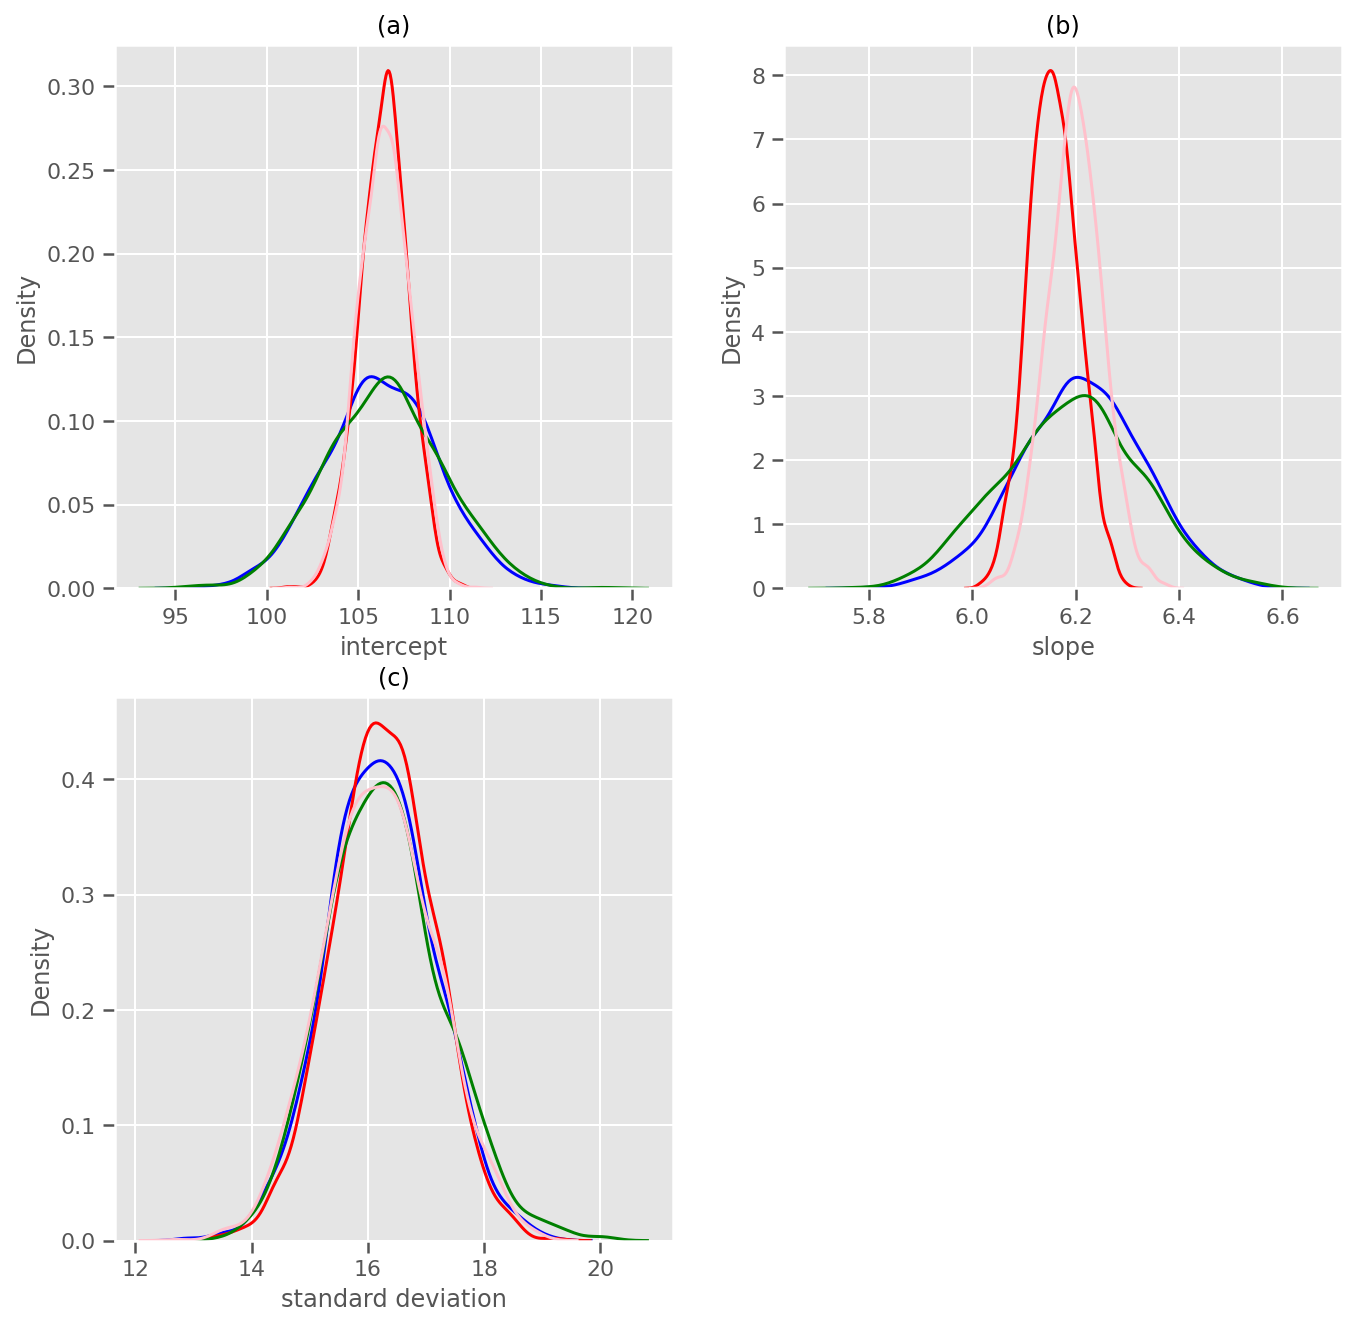

In [ ]:
from matplotlib import pyplot as plt
sns.set_color_codes("pastel") # deep, muted, pastel, dark, bright, colorblind
fig, axes = plt.subplots(2, 2, figsize=(11, 11))
myplot=sns.kdeplot(ax=axes[0,0],x='alpha_i',data=myres_iaf_df,color='blue')
myplot.set(xlabel='intercept')
myplot.set(title="(a)")
sns.kdeplot(ax=axes[0,0],x='alpha_i',data=myres_bi,color='red')
sns.kdeplot(ax=axes[0,0],x='alpha_i',data=res_jags,color='green')
sns.kdeplot(ax=axes[0,0],x='alpha_i',data=myres_df,color='pink')

myplot=sns.kdeplot(ax=axes[0,1],x='beta_i',data=myres_iaf_df,color='blue')
myplot.set(xlabel='slope')
myplot.set(title="(b)")
sns.kdeplot(ax=axes[0,1],x='beta_i',data=myres_bi,color='red')
sns.kdeplot(ax=axes[0,1],x='beta_i',data=res_jags,color='green')
sns.kdeplot(ax=axes[0,1],x='beta_i',data=myres_df,color='pink')

myplot=sns.kdeplot(ax=axes[1,0],x='tau_c',data=myres_iaf_df,color='blue')
myplot.set(xlabel='standard deviation')
myplot.set(title="(c)")
sns.kdeplot(ax=axes[1,0],x='tau_c',data=myres_bi,color='red')
sns.kdeplot(ax=axes[1,0],x='tau_c',data=res_jags,color='green')
sns.kdeplot(ax=axes[1,0],x='tau_c',data=myres_df,color='pink')
fig.delaxes(axes[1,1])
#plt.savefig('comp.png')
#files.download("comp.png")
